# Contents of Readme:

dict_keys(['SERIALIZE_VERSION', 'game_name', 'options.paint_vel_info', 'options.use_generated_assets', 'options.use_monochrome_assets', 'options.restrict_themes', 'options.use_backgrounds', 'options.center_agent', 'options.debug_mode', 'options.distribution_mode', 'options.use_sequential_levels', 'options.use_easy_jump', 'options.plain_assets', 'options.physics_mode', 'grid_step', 'level_seed_low', 'level_seed_high', 'game_type', 'game_n', 'level_seed_rand_gen.is_seeded', 'level_seed_rand_gen.str', 'rand_gen.is_seeded', 'rand_gen.str', 'step_data.reward', 'step_data.done', 'step_data.level_complete', 'action', 'timeout', 'current_level_seed', 'prev_level_seed', 'episodes_remaining', 'episode_done', 'last_reward_timer', 'last_reward', 'default_action', 'fixed_asset_seed', 'cur_time', 'is_waiting_for_step', 'grid_size', 'ents.size', 'ents', 'use_procgen_background', 'background_index', 'bg_tile_ratio', 'bg_pct_x', 'char_dim', 'last_move_action', 'move_action', 'special_action', 'mixrate'

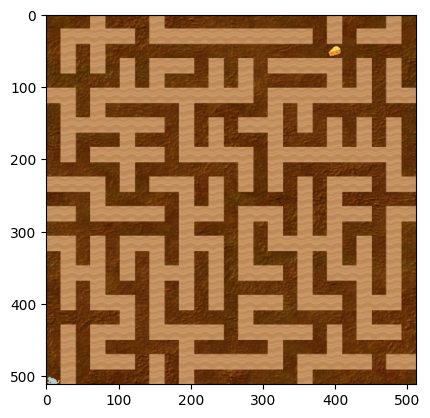

In [11]:
import matplotlib.pyplot as plt
from procgen_tools import maze
# Create a maze environment
venv = maze.create_venv(1, start_level=100, num_levels=1)
# Parse the environment state
env_state = maze.state_from_venv(venv, 0)
# Display state values
print(env_state.state_vals.keys())
# Show a rendering of the first
venv.reset()
render = venv.render(mode='rgb_array')
plt.imshow(render)
plt.show()

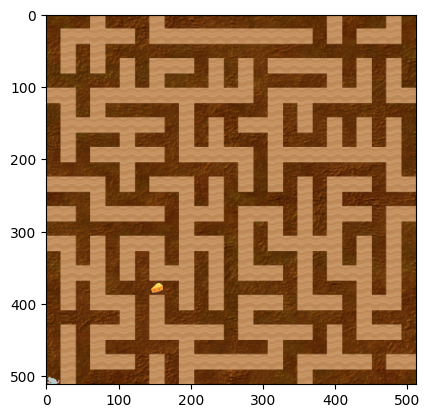

In [12]:
maze.move_cheese_in_state(env_state, (6,7))
venv.env.callmethod('set_state', [env_state.state_bytes])
venv.reset()
render = venv.render(mode='rgb_array')
plt.imshow(render)
plt.show()

In [13]:
import torch as t

Policy loaded successfully


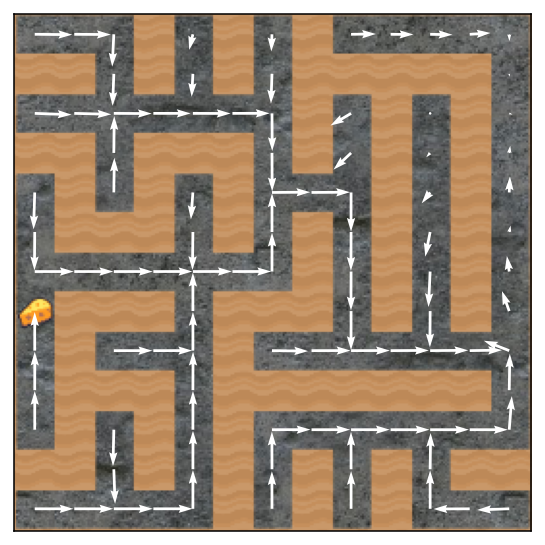

In [14]:
from procgen_tools import maze, vfield, models

policy = models.load_policy('trained_models/maze_I/model_rand_region_1.pth', 15, t.device('cpu'))
print("Policy loaded successfully")

# Create and show a vector field
venv = maze.create_venv(1, start_level=0, num_levels=1)
vf_original = vfield.vector_field(venv, policy)
vfield.plot_vf(vf_original)
plt.show()

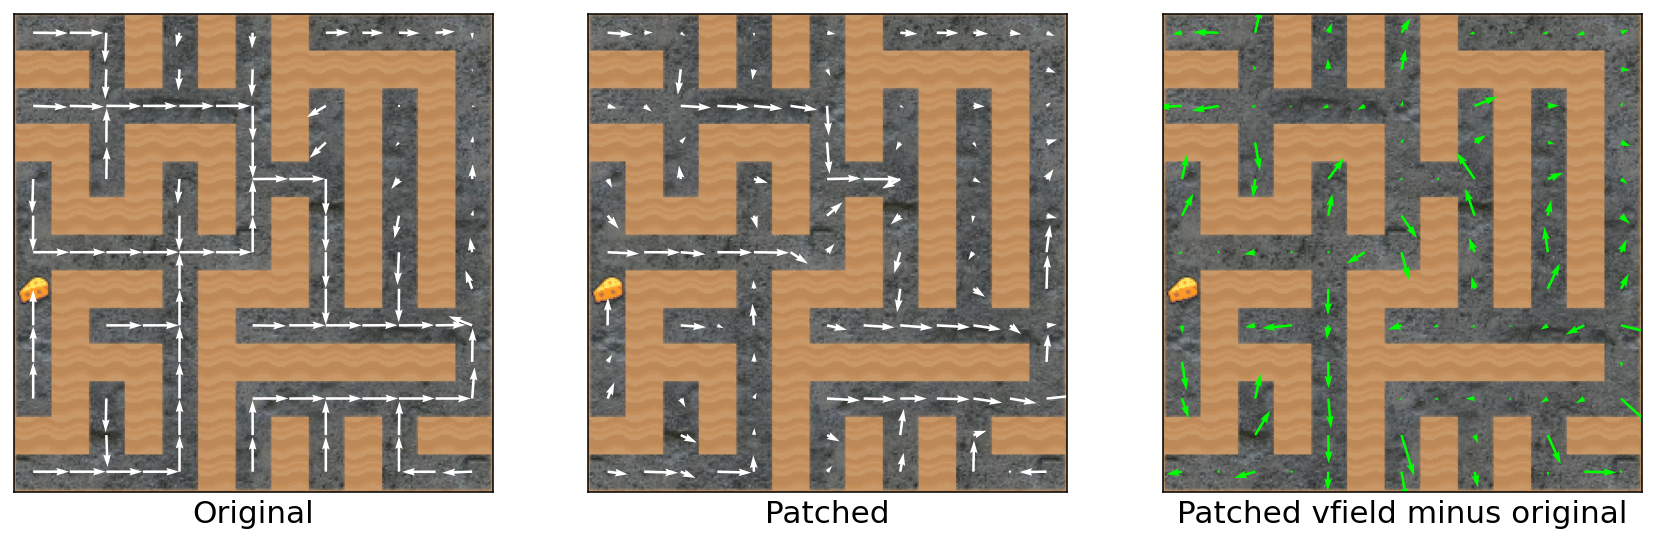

In [15]:
import circrl.module_hook as cmh
hook = cmh.ModuleHook(policy)
patches = {'embedder.block2.res1.resadd_out': lambda outp: outp + 0.2*t.randn_like(outp)}
venv = maze.create_venv(1, start_level=0, num_levels=1)
with hook.use_patches(patches):
    vf_patched = vfield.vector_field(venv, hook.network)
vfield.plot_vfs(vf_original, vf_patched)
plt.show()

# 1. Activation Map Visualization

The introduction of convolutional networks by Yann LeCun marked a significant milestone in the field of machine learning, particularly for image processing. This innovation enabled models to effectively comprehend spatial relationships between pixels within localized regions of an image. On top of this, convolutional networks offer greater interpretability compared to traditional dense layers, as their outputs are transformed versions of the input images. These visualizations provide a clear depiction of kernel activations, allowing us to understand what specific features each kernel captures from the input image.

### 1.1 Model Summary
What's important as of now is to get a summary of the exact neural network we're working with. To do this, we can import summary from a library dubbed "torchinfo"

In [16]:
# Let's get some sort of interpretation for what our model looks like
from torchinfo import summary
print(render.shape)

(512, 512, 3)


The rendered image is of size 512x512x3, but this image is only for the purposes of human viewing. The input image going into the model is actually of size 3x64x64. The below code has been transferred over from the function vector_field() from procgen_tools/vfield to provide insight regarding the movement of data through the code.

In [17]:
venv = maze.create_venv(1, start_level=100, num_levels=1)
new_state = maze.copy_venv(venv, 0)
venv_all, (
        legal_mouse_positions,
        grid,) = maze.venv_with_all_mouse_positions(new_state)

batched_obs = t.tensor(
        venv_all.reset(), dtype=t.float32
)

print(batched_obs.shape)

torch.Size([336, 3, 64, 64])


In [18]:
summary(policy, input_data=batched_obs)

Layer (type:depth-idx)                             Output Shape              Param #
CategoricalPolicy                                  --                        --
├─InterpretableImpalaModel: 1-1                    [336, 256]                --
│    └─InterpretableImpalaBlock: 2-1               [336, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                            [336, 64, 64, 64]         1,792
│    │    └─MaxPool2d: 3-2                         [336, 64, 32, 32]         --
│    │    └─InterpretableResidualBlock: 3-3        [336, 64, 32, 32]         73,856
│    │    └─InterpretableResidualBlock: 3-4        [336, 64, 32, 32]         73,856
│    └─InterpretableImpalaBlock: 2-2               [336, 128, 16, 16]        --
│    │    └─Conv2d: 3-5                            [336, 128, 32, 32]        73,856
│    │    └─MaxPool2d: 3-6                         [336, 128, 16, 16]        --
│    │    └─InterpretableResidualBlock: 3-7        [336, 128, 16, 16]        295,168
│    │    └─Int

The above tells us what the model looks like. This lets us identify points of particular interest. 

### 1.2 Hooks
The above block tells us that this model is quite deep, let's try visualizing some kernels just to see what the model is looking at

In [19]:
import numpy
from tqdm import tqdm

Let's check what the maze looks like

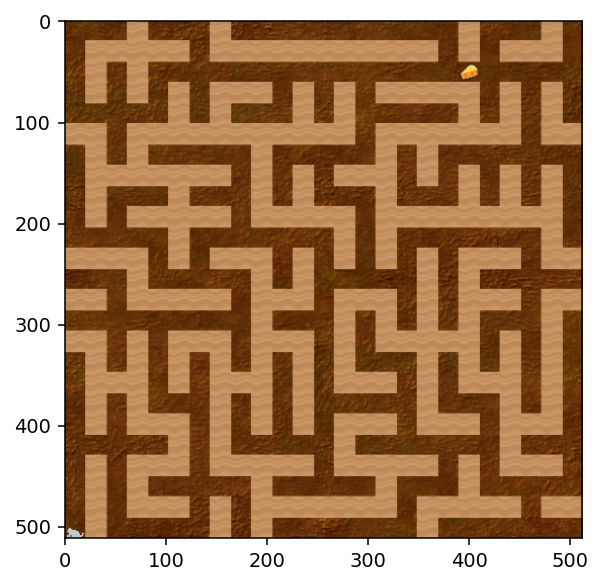

In [20]:
render = venv.render(mode='rgb_array')
plt.imshow(render)
plt.show()

For a sanity check, we can check what our maps themselves look like as they are inputted into the model

## scrap: export for grand tour

In [21]:
def to_ndsp_file(data, labels=None, title="untitled", dimAx=0, afAx=None):

    # move from torch to numpy if not already done
    if not type(data) == numpy.ndarray:
        data = data.detach().numpy()
    
    # get the dimension indices
    axes = list(range(data.ndim))
    
    # move dimension vals to end
    axes.remove(dimAx)
    axes.append(dimAx)
    
    # move animation frames to start
    if not afAx is None:
        axes.remove(afAx)
        axes.insert(0,afAx)
    
    # reshape data
    transposed_data = numpy.transpose(data, axes=axes)
    shape = transposed_data.shape
    if not afAx is None:
        reshaped_data = transposed_data.reshape([shape[0],-1,shape[-1]])
    else:
        reshaped_data = transposed_data.reshape([-1,shape[-1]])

    # get shape info for flname
    shape = reshaped_data.shape
    if afAx is None:
        af = 1
    else:
        af = shape[0]
    dp = shape[-2]
    dim = shape[-1]

    # save data
    flname = f"{title}._{af}af_{dp}dp_{dim}dim_.bin"
    reshaped_data.tofile(flname)

    # save labels if any
    if not labels is None:
        if labels=="zeros":
            labels = numpy.zeros(dp,dtype=numpy.uint8)
        
        flname = f"{title}_labels._{af}af_{dp}dp_{dim}dim_.bin"
        labels.tofile(flname)
            

In [22]:
# to_ndsp_file(batched_obs[0],
#             labels=None,
#             title="img_test_2",
#             dimAx=0,
#             afAx=2) ## don't do this, use none

In [23]:
to_ndsp_file(batched_obs[0],
             labels="zeros",
             title="img_test_2",
             dimAx=0,
             afAx=None)

In [24]:
pointsss = numpy.fromfile("softmax-test.bin", dtype=numpy.float32)

In [25]:
pointsss.shape

(1000000,)

In [26]:
pointsss.reshape([100,1000,-1]).shape

(100, 1000, 10)

In [27]:
labels = numpy.fromfile("labels-test.bin", dtype=numpy.uint8)

In [28]:
labels.shape

(1000,)

In [29]:
labels[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

In [30]:
batched_obs[0].shape

torch.Size([3, 64, 64])

In [31]:
transposed_img = numpy.transpose(batched_obs[0], axes=[1,2,0])
transposed_img.shape

torch.Size([64, 64, 3])

In [32]:
im4sca = transposed_img.reshape([64*64,3])

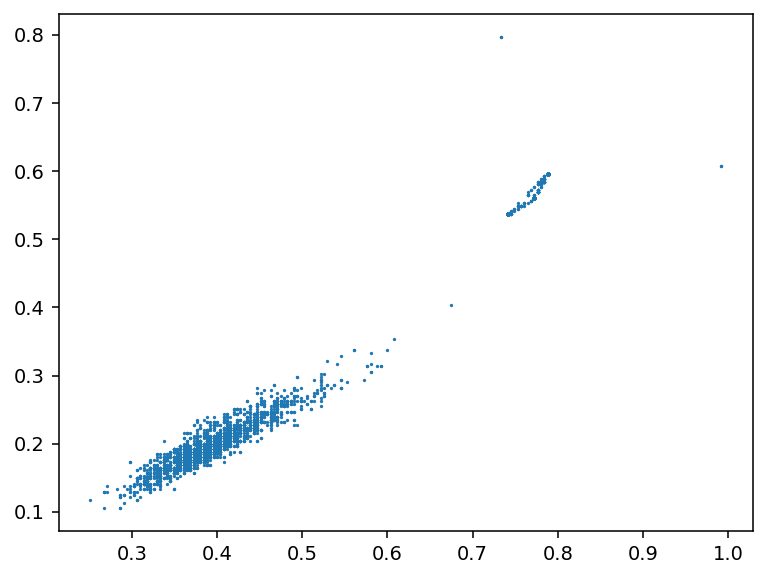

In [33]:
plt.scatter(im4sca[:,0],im4sca[:,1],s=.5)

In [34]:
transposed_img.min(), transposed_img.max()

(tensor(0.0078), tensor(0.9922))

In [35]:
transposed_img.dtype

torch.float32

In [36]:
type(transposed_img.detach().numpy())

numpy.ndarray

In [37]:
###transposed_img.detach().numpy().tofile("test_in_pix.bin")

In [38]:
labels = numpy.zeros(4096,dtype=numpy.uint8)
labels.dtype

dtype('uint8')

In [39]:
labels.shape

(4096,)

In [40]:
###labels.tofile("test_in_pix_lab.bin")

## ===================

In [41]:
batched_obs[0].shape

torch.Size([3, 64, 64])

In [334]:
img = batched_obs[91].numpy().transpose((1,2,0))

In [327]:
img.max()

0.99215686

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.9764705].


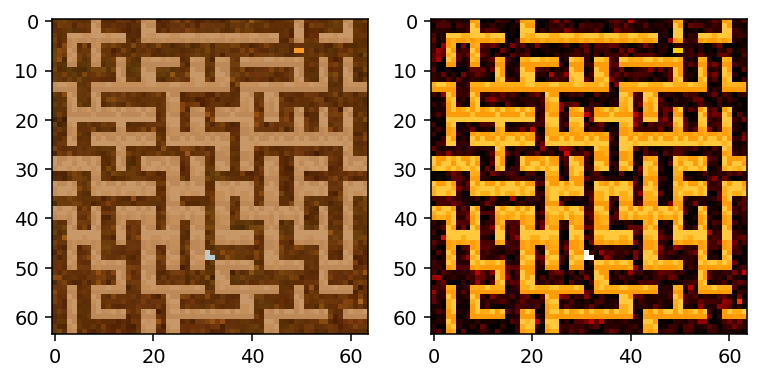

In [338]:
img = batched_obs[91].numpy().transpose((1,2,0))
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(img)
img = 3*img-1
ax2.imshow(img)

In [141]:
batched_obs[91].shape

torch.Size([3, 64, 64])

We can identify the yellow block at $y=\set{49, 50}, x\approx7$ as the cheese/goal and the grey block at $y\approx8, x=63$ as the mouse/actor. Notably also, the image is flipped along the y=-x axis.

We can now focus specifically on isolating certain model layers themselves. To do that, we can use the [hook feature](https://pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_forward_hook.html) implemented by pytorch, specifically forward hooks. 

A forward hook in PyTorch is a function that is executed during the forward pass of the model, specifically when data flows through the layer it is attached to. The hook_fn function must follow the signature hook_fn(module, input, output), where module is the fc layer, and input and output are the data entering and exiting the layer, respectively.

In [44]:
# We define our hook here
def hook_fn(m, i, o):
    visualisation[m] = o 

This let's us define a dictionary dubbed "visualisation" and input into that dictionary the output o of a certain layer m. Using this, we can extract feature maps.

### 1.3 Convolutional Layer Feature Maps

First let's determine the feature maps of our very first convolutional layer. In the model architecture, it is found in the first impala block at 3-1.

In [45]:
visualisation = {}

# We set our hook
h = policy.embedder.block1.conv.register_forward_hook(hook_fn)

In [46]:
# Then we send our data through, specifically the first map in our batched observations
output = policy(batched_obs[:1])

In [47]:
# Remove our hook 
h.remove()

## scrap: exporting activations for grand tour

In [48]:
policy.embedder

InterpretableImpalaModel(
  (block1): InterpretableImpalaBlock(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (res1): InterpretableResidualBlock(
      (relu1): ReLU()
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (resadd): ResidualAdd()
    )
    (res2): InterpretableResidualBlock(
      (relu1): ReLU()
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (resadd): ResidualAdd()
    )
  )
  (block2): InterpretableImpalaBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=F

In [143]:
list(visualisation.keys())

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]

In [49]:
outp = list(visualisation.items())[0][1]

In [50]:
outp.shape # batch, channels, x, y

torch.Size([1, 64, 64, 64])

In [51]:
to_ndsp_file(outp,
             labels="zeros",
             title="b1_conv",
             dimAx=1,
             afAx=None)

In [52]:
pltdata = outp.detach().numpy().reshape([64,-1])

In [53]:
pltdata = pltdata.transpose([1,0])
pltdata.shape

(4096, 64)

## scrap: clustering for coloring

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
AgglomerativeClustering(n_clusters=2, *, metric='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='ward', distance_threshold=None, compute_distances=False)

In [144]:
from scipy.cluster import hierarchy, dendrogram

heirZ = hierarchy.linkage(pltdata)

heirTree = hierarchy.to_tree(heirZ)

In [150]:
heirTree.dist

0.5644236232303813

In [154]:
heirTree.right.dist

0.5142763015604371

In [157]:
heirTree.id

8190

In [161]:
from scipy.cluster.hierarchy import dendrogram

(-0.02, 0.6)

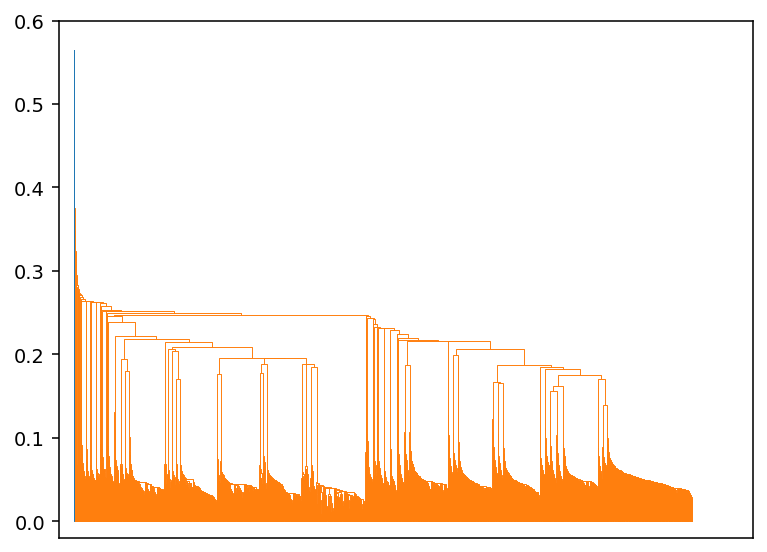

In [319]:
fig, ax = plt.subplots()
acf = ax.add_collection
def linmodacf(colec):
    colec.set(linewidth=0.5,)
    acf(colec)
ax.add_collection = linmodacf

ddg=dendrogram(heirZ,
           count_sort='ascending',
           no_labels=True,
           ax=ax,
           )
ax.set_xlim([-1000,45000])
ax.set_ylim([-0.02,0.6])

In [270]:
cole[0].get_linewidths()

array([1])

In [262]:
len(cole[0].get_paths())

4092

In [212]:
tuple(x/4092 for x in range(4092))

In [166]:
from scipy.cluster.hierarchy import fcluster

In [199]:
heirT = list(fcluster(heirZ, x, criterion='distance') for x in (.3, .265, .26, .25, .23) )


In [ ]:
##### warning, copied from below ####

In [200]:
heirT_img = list(x.reshape([64,64]) for x in heirT)

In [201]:
heirColo_img = list(colarrs[x-1] for x in heirT_img)

In [202]:
heirColo_img[0].shape

(64, 64, 3)

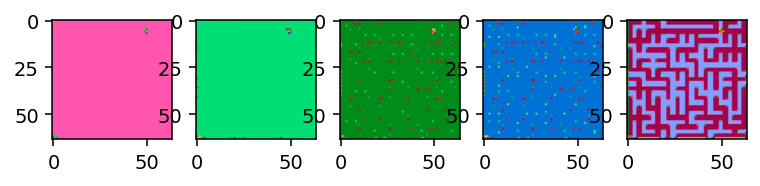

In [204]:
fig, axes = plt.subplots(1,5)
list(ax.imshow(im) for ax,im in zip(axes,heirColo_img))

In [196]:
# this too would be cool animated... but probs better manually colored.

/tmp/ipykernel_1677875/1247284785.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Paste Test:
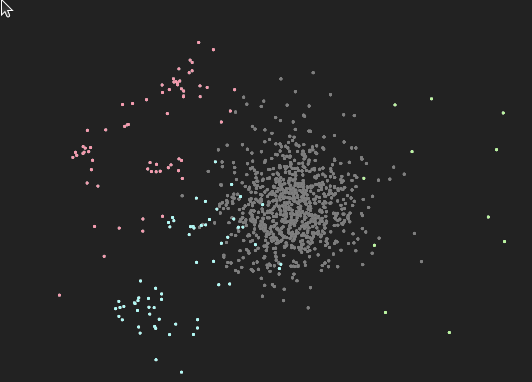
It works : )

In [54]:
from scipy.cluster.hierarchy import fclusterdata

In [55]:
T = fclusterdata(pltdata, .2, criterion='distance', metric='euclidean', depth=2, method='single', R=None)

In [56]:
T.max()

63

In [57]:
T.shape

(4096,)

In [58]:
unique, counts = numpy.unique(T, return_counts=True)
counts.max(), unique

(1323,
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], dtype=int32))

In [59]:
cmap = plt.colormaps['tab20_r']

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


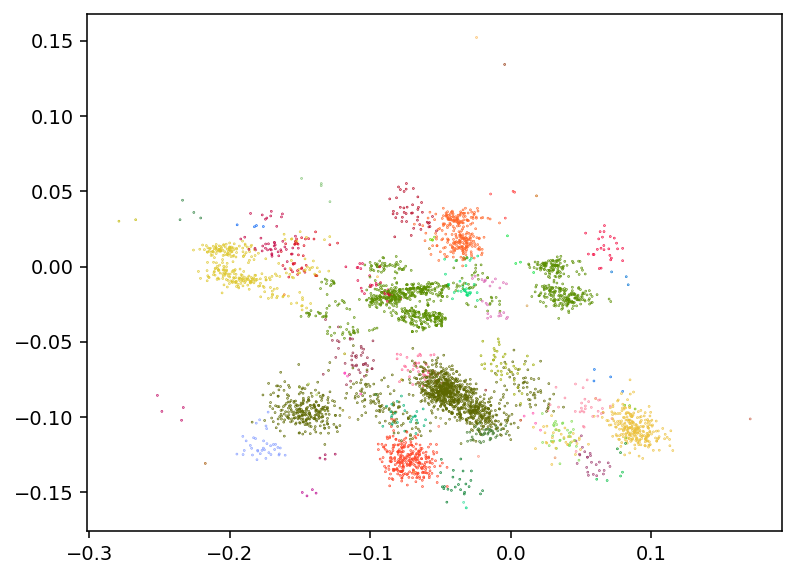

In [74]:
plt.scatter(pltdata[:,0],pltdata[:,63],s=.1, c=colarrs[T-1]/255)

In [157]:
#T.dtype = numpy.uint8

In [172]:
T = numpy.array(T, dtype=numpy.uint8)

In [173]:
T.shape

(4096,)

In [174]:
T.tofile("b1_conv-cluster-labels.bin")

## colors for clusters

In [61]:
colhex = ["#ff55af", "#00e237", "#0161f5", "#72d400", "#026beb",
        "#79c000", "#ff3cb9", "#00be41", "#ba008b", "#00de74",
        "#f30039", "#38df9f", "#da0014", "#00b175", "#ff3635",
        "#018b18", "#bf005e", "#82dc51", "#0172d5", "#c0b700",
        "#859dff", "#dec72d", "#da66b3", "#5a8e00", "#df003e",
        "#007b2a", "#ff3f21", "#2d803f", "#c20041", "#b3d258",
        "#a5024d", "#9cab00", "#9b356a", "#82c375", "#b5001e",
        "#467e32", "#ff6695", "#ab9d00", "#972945", "#ecc13d",
        "#fc85a0", "#5d6800", "#ff6426", "#8b993f", "#bb3100",
        "#898300", "#ff6f5c", "#dca300", "#9c2627", "#feba41",
        "#d5656a", "#fdb95a", "#92330a", "#b0933d", "#f67200",
        "#d8a456", "#cc6200", "#ff8f79", "#aa7300", "#cc6951",
        "#ff9d49", "#a35200", "#e99261"] ;


In [62]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return numpy.array(list(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3)))

In [63]:
colarrs = numpy.array(list(hex_to_rgb(x) for x in colhex))

# scrap: centroids??

In [119]:
cluster_index = 27

In [120]:
T==cluster_index

array([False, False, False, ..., False, False, False])

In [121]:
(T==cluster_index).sum()

271

In [122]:
cluster_points = pltdata[ T==cluster_index ]

In [123]:
cluster_points.shape

(271, 64)

In [124]:
cluster_centroid = cluster_points.mean(axis=0)

In [125]:
cluster_centroid.shape

(64,)

In [126]:
cluster_centroid

array([-0.07259258, -0.06660707, -0.07876626,  0.06043769, -0.11108983,
        0.02075574,  0.07857369, -0.02720029, -0.07643177,  0.01454504,
        0.01033048, -0.0100347 , -0.05482912, -0.10466239, -0.01899134,
        0.01465384, -0.1632768 ,  0.00502844,  0.02220704,  0.00319233,
        0.0235266 , -0.06831989, -0.0981909 ,  0.02284395, -0.17039259,
       -0.03143549, -0.09342681, -0.04105479, -0.03400958, -0.00727519,
        0.02088817, -0.0500332 , -0.02480849, -0.00981838, -0.03244572,
       -0.05411183, -0.16964199,  0.11877593, -0.00229389, -0.01494619,
       -0.00959849,  0.01023481, -0.04473497, -0.10261974, -0.07790997,
       -0.0388    , -0.09240068,  0.01369027, -0.10814858, -0.05306621,
       -0.04694344, -0.03817527, -0.04111002, -0.03898228, -0.04096042,
       -0.01572585,  0.08398091, -0.09634889, -0.08625971, -0.00426449,
       -0.05143697,  0.03636021,  0.01152208, -0.12829672], dtype=float32)

### Plot the centroid

In [127]:
colarrs[0]/255

array([1.        , 0.33333333, 0.68627451])

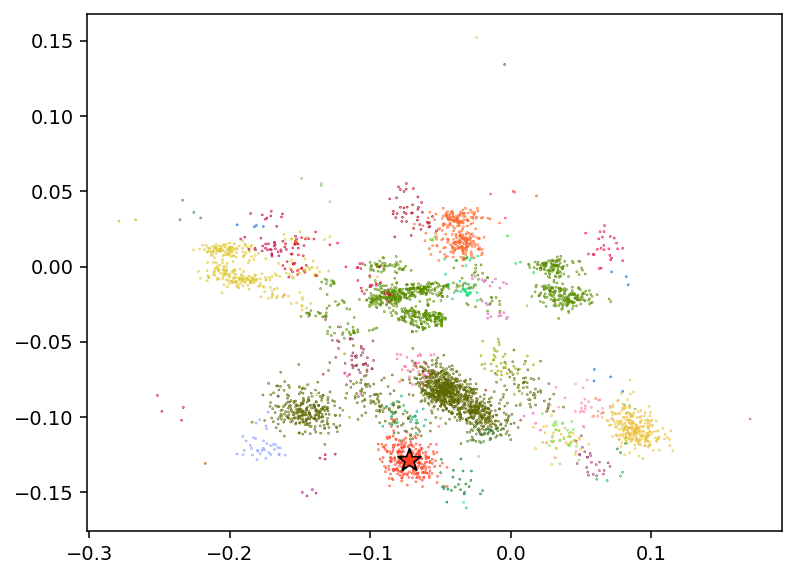

In [128]:
fig, ax = plt.subplots()

# plot rest of points
ax.scatter(pltdata[:,0],pltdata[:,63],s=.1, c=colarrs[T-1]/255)

# plot centroid
ax.scatter(cluster_centroid[0],cluster_centroid[63],
           s=150,
           c=[[0,0,0]],
           marker="*")
ax.scatter(cluster_centroid[0],cluster_centroid[63],
           s=50,
           c=[colarrs[cluster_index-1]/255],
           marker="*")

## Here is color by cluster

In [181]:
T_img = T.reshape([64,64])
T_img.shape

(64, 64)

In [191]:
colarrs[0]

array([255,  85, 175])

In [192]:
foo = numpy.array([0,1,2])
foo, colarrs[foo]

(array([0, 1, 2]),
 array([[255,  85, 175],
        [  0, 226,  55],
        [  1,  97, 245]]))

In [204]:
colo_img = colarrs[T_img-1]

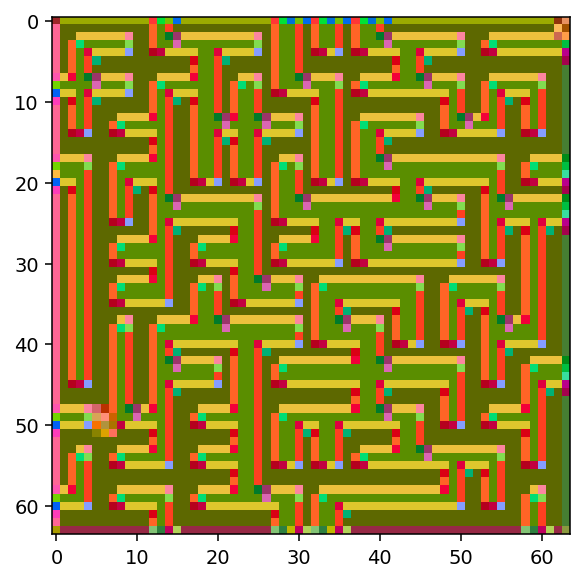

In [206]:
plt.imshow(colo_img.transpose([1,0,2]))
plt.show()

### done color by cluster

In [ ]:
focus = 0.0

# We only have one key in here, but the key itself is the layer architecture, which is annoying to type. This is easier.
for v in visualisation.keys():
    focus = visualisation[v]
    break

# Let's check out what our activations shape is.
focus.shape

In [28]:
focus[0].shape

torch.Size([64, 64, 64])

In [32]:
focus[0].detach().numpy().tofile("test.bin")

100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 2459.66it/s]


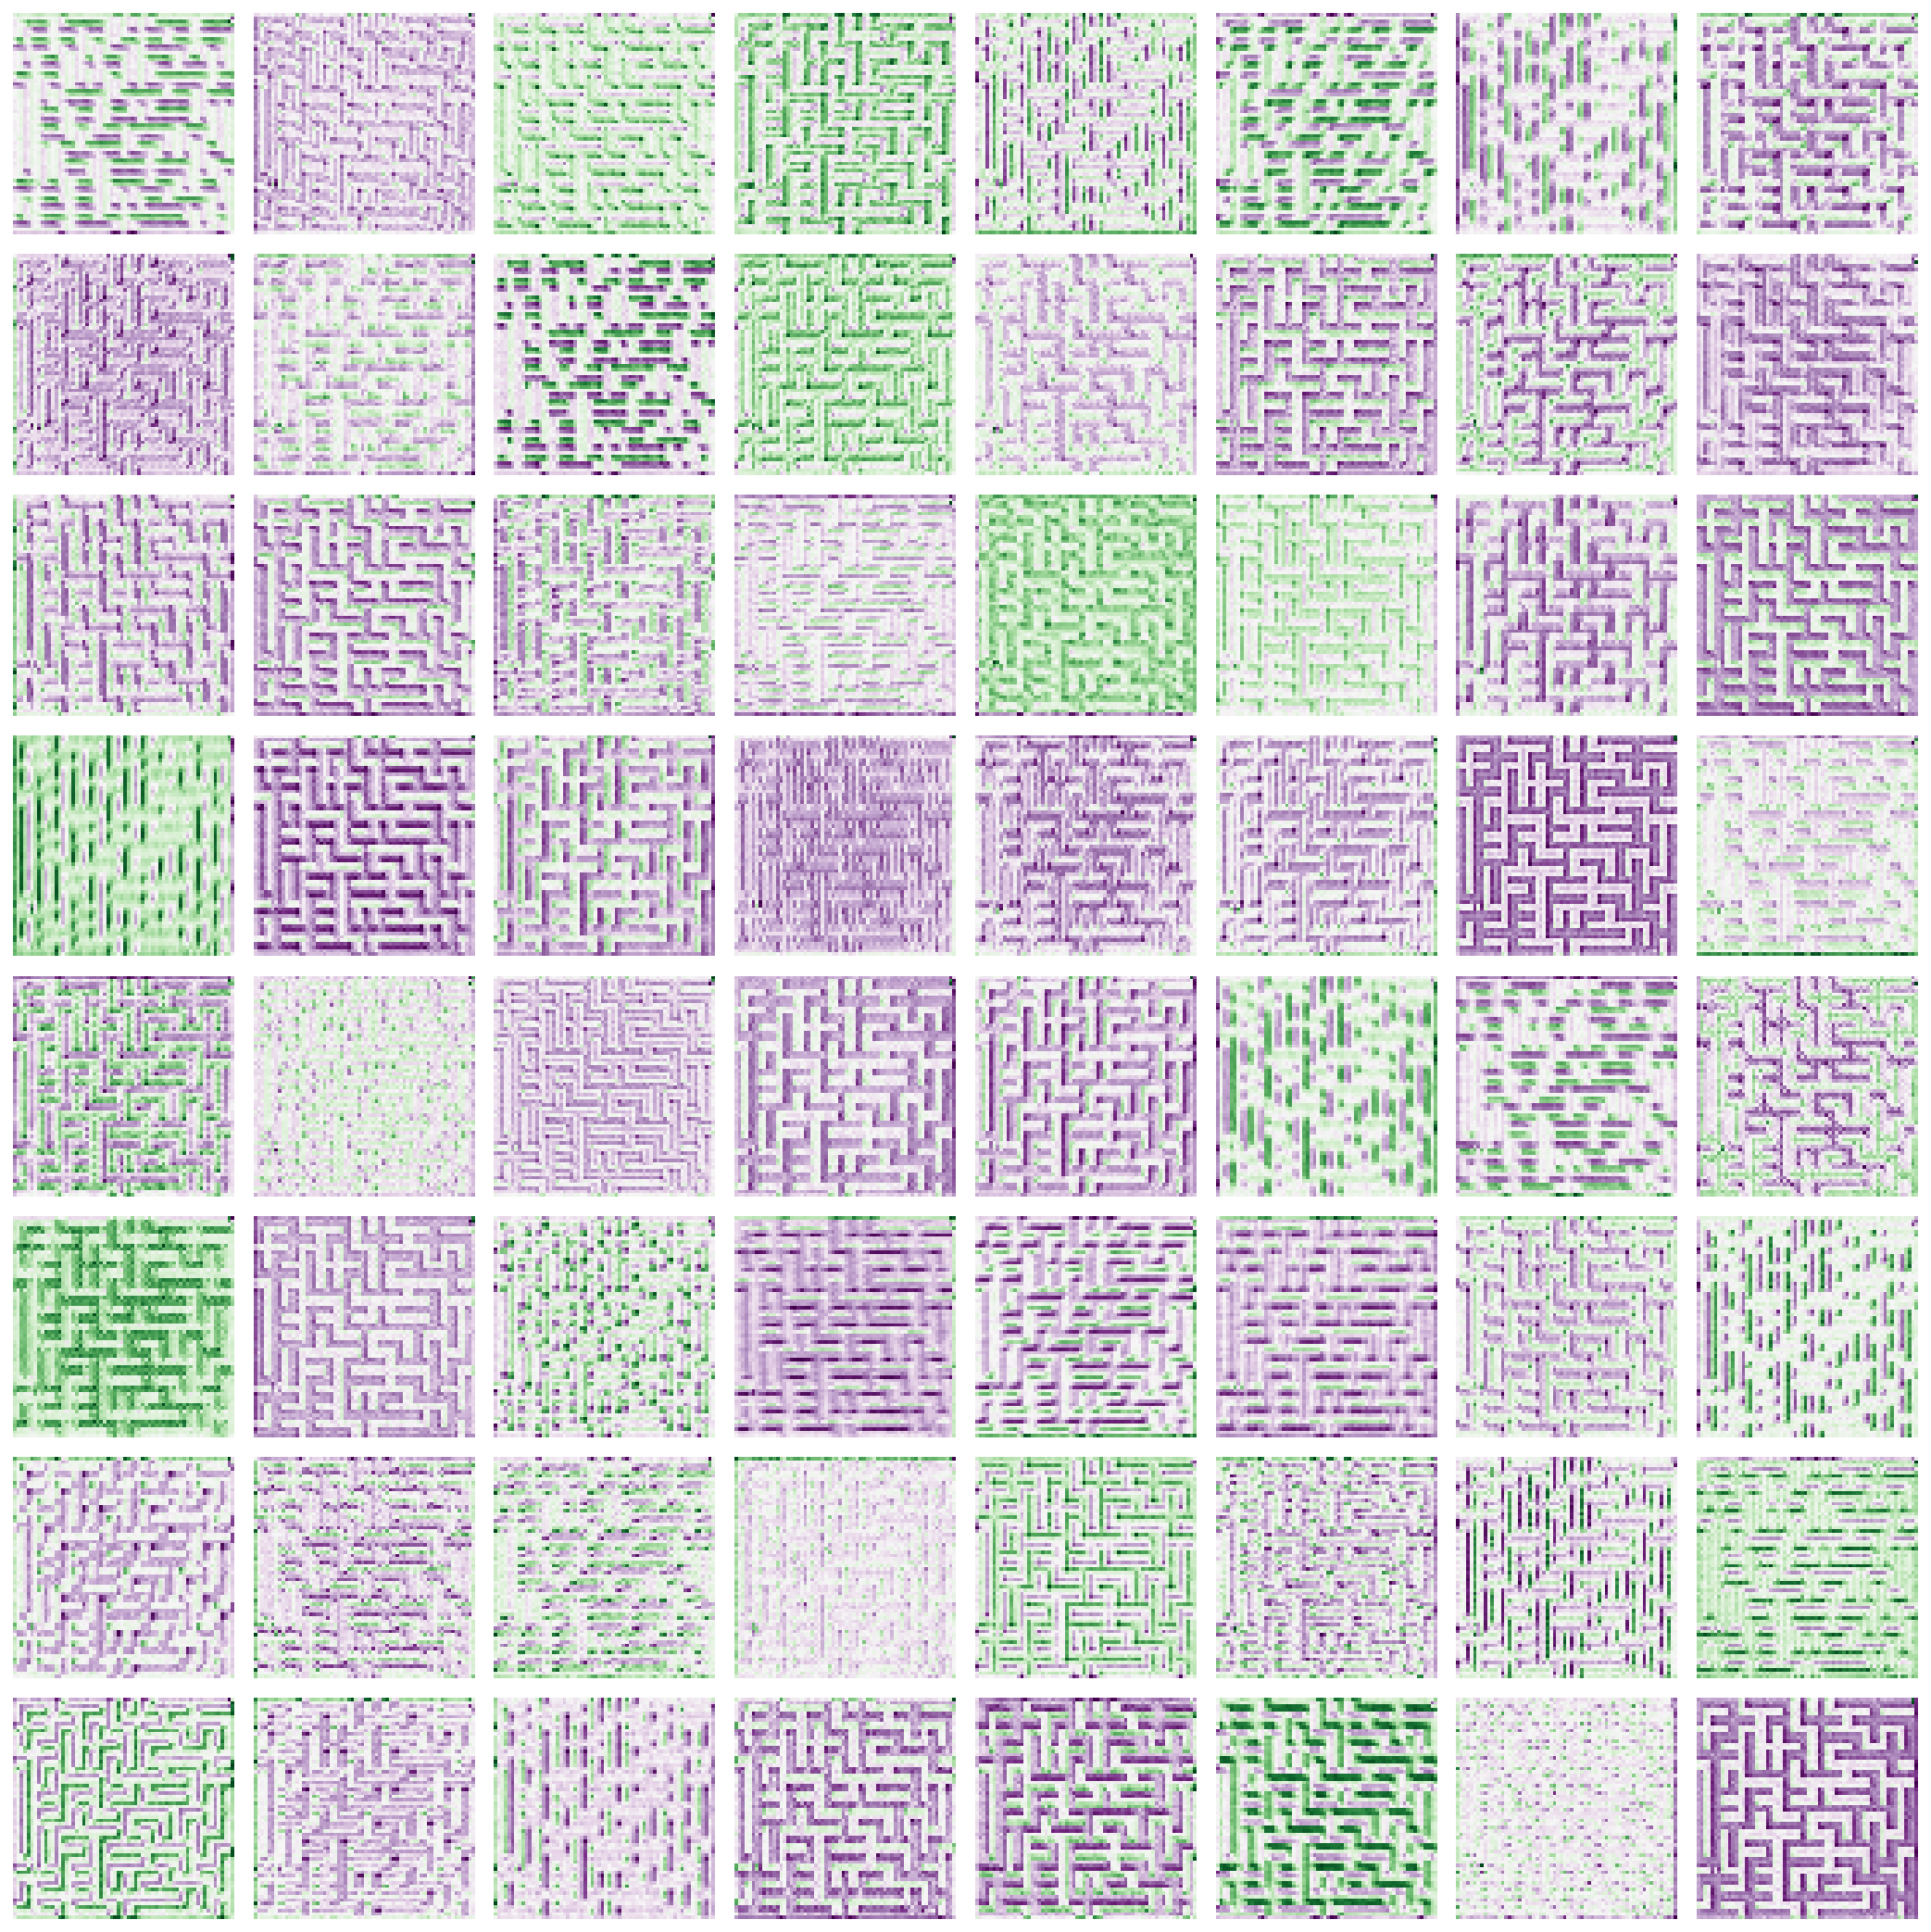

In [13]:
# It is the shape we expected from conv 3-1, now we can visualize all 64 feature maps.
fig, ax = plt.subplots(8, 8, figsize=(15, 15))
axes = ax.ravel()

for i in tqdm(range(focus[0].shape[0])):
    row, col = divmod(i, 8)
    axes[i].imshow(focus[0, i, :, :].detach().numpy().T, cmap='PRGn')
    axes[i].axis('off')  # Optionally, turn off axis labels

plt.tight_layout()
plt.show()

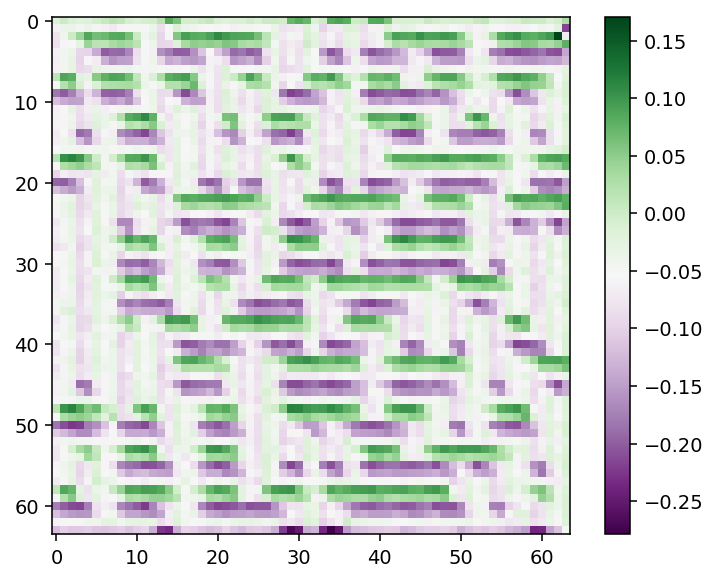

In [14]:
# Let's isolate one and plot it with a colormap so we can identify activation patterns
plt.imshow(focus[0, 0, :, :].detach().numpy().T, cmap='PRGn')
plt.colorbar()
plt.show()

As a general rule, the higher the activation in that area corresponds to the color green. We opt to use a diverging colormap instead of a sequential one because it more effectively highlights both high and low activation areas, making it easier to distinguish between different levels of activity and identify significant patterns in the data. This is particularly useful for detecting subtle variations in activation that might be overlooked with a sequential colormap.

Consequently, we can categorize the resulting outputs into a few broad categories. 


1. Some activate well on certain colours, i.e. light brown, which simultaneously highlight where the walls/unwalkable things are. (see image 64)
2. Some activate on shapes, identifying vertical and horizontal lines (See first image, sixth image)
3. Some activate on corners
4. Some are pretty uninterpretable
5. Some are redundancies of the above 4.

These visualizations provide an initial insight into what the model perceives and understands. However, the first convolutional layer typically offers limited information. It is the intermediate patterns, resulting from combinations of higher-level kernels, that significantly enhance the model's comprehension and representation of the data.

torch.Size([335, 128, 32, 32])


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 2780.30it/s]


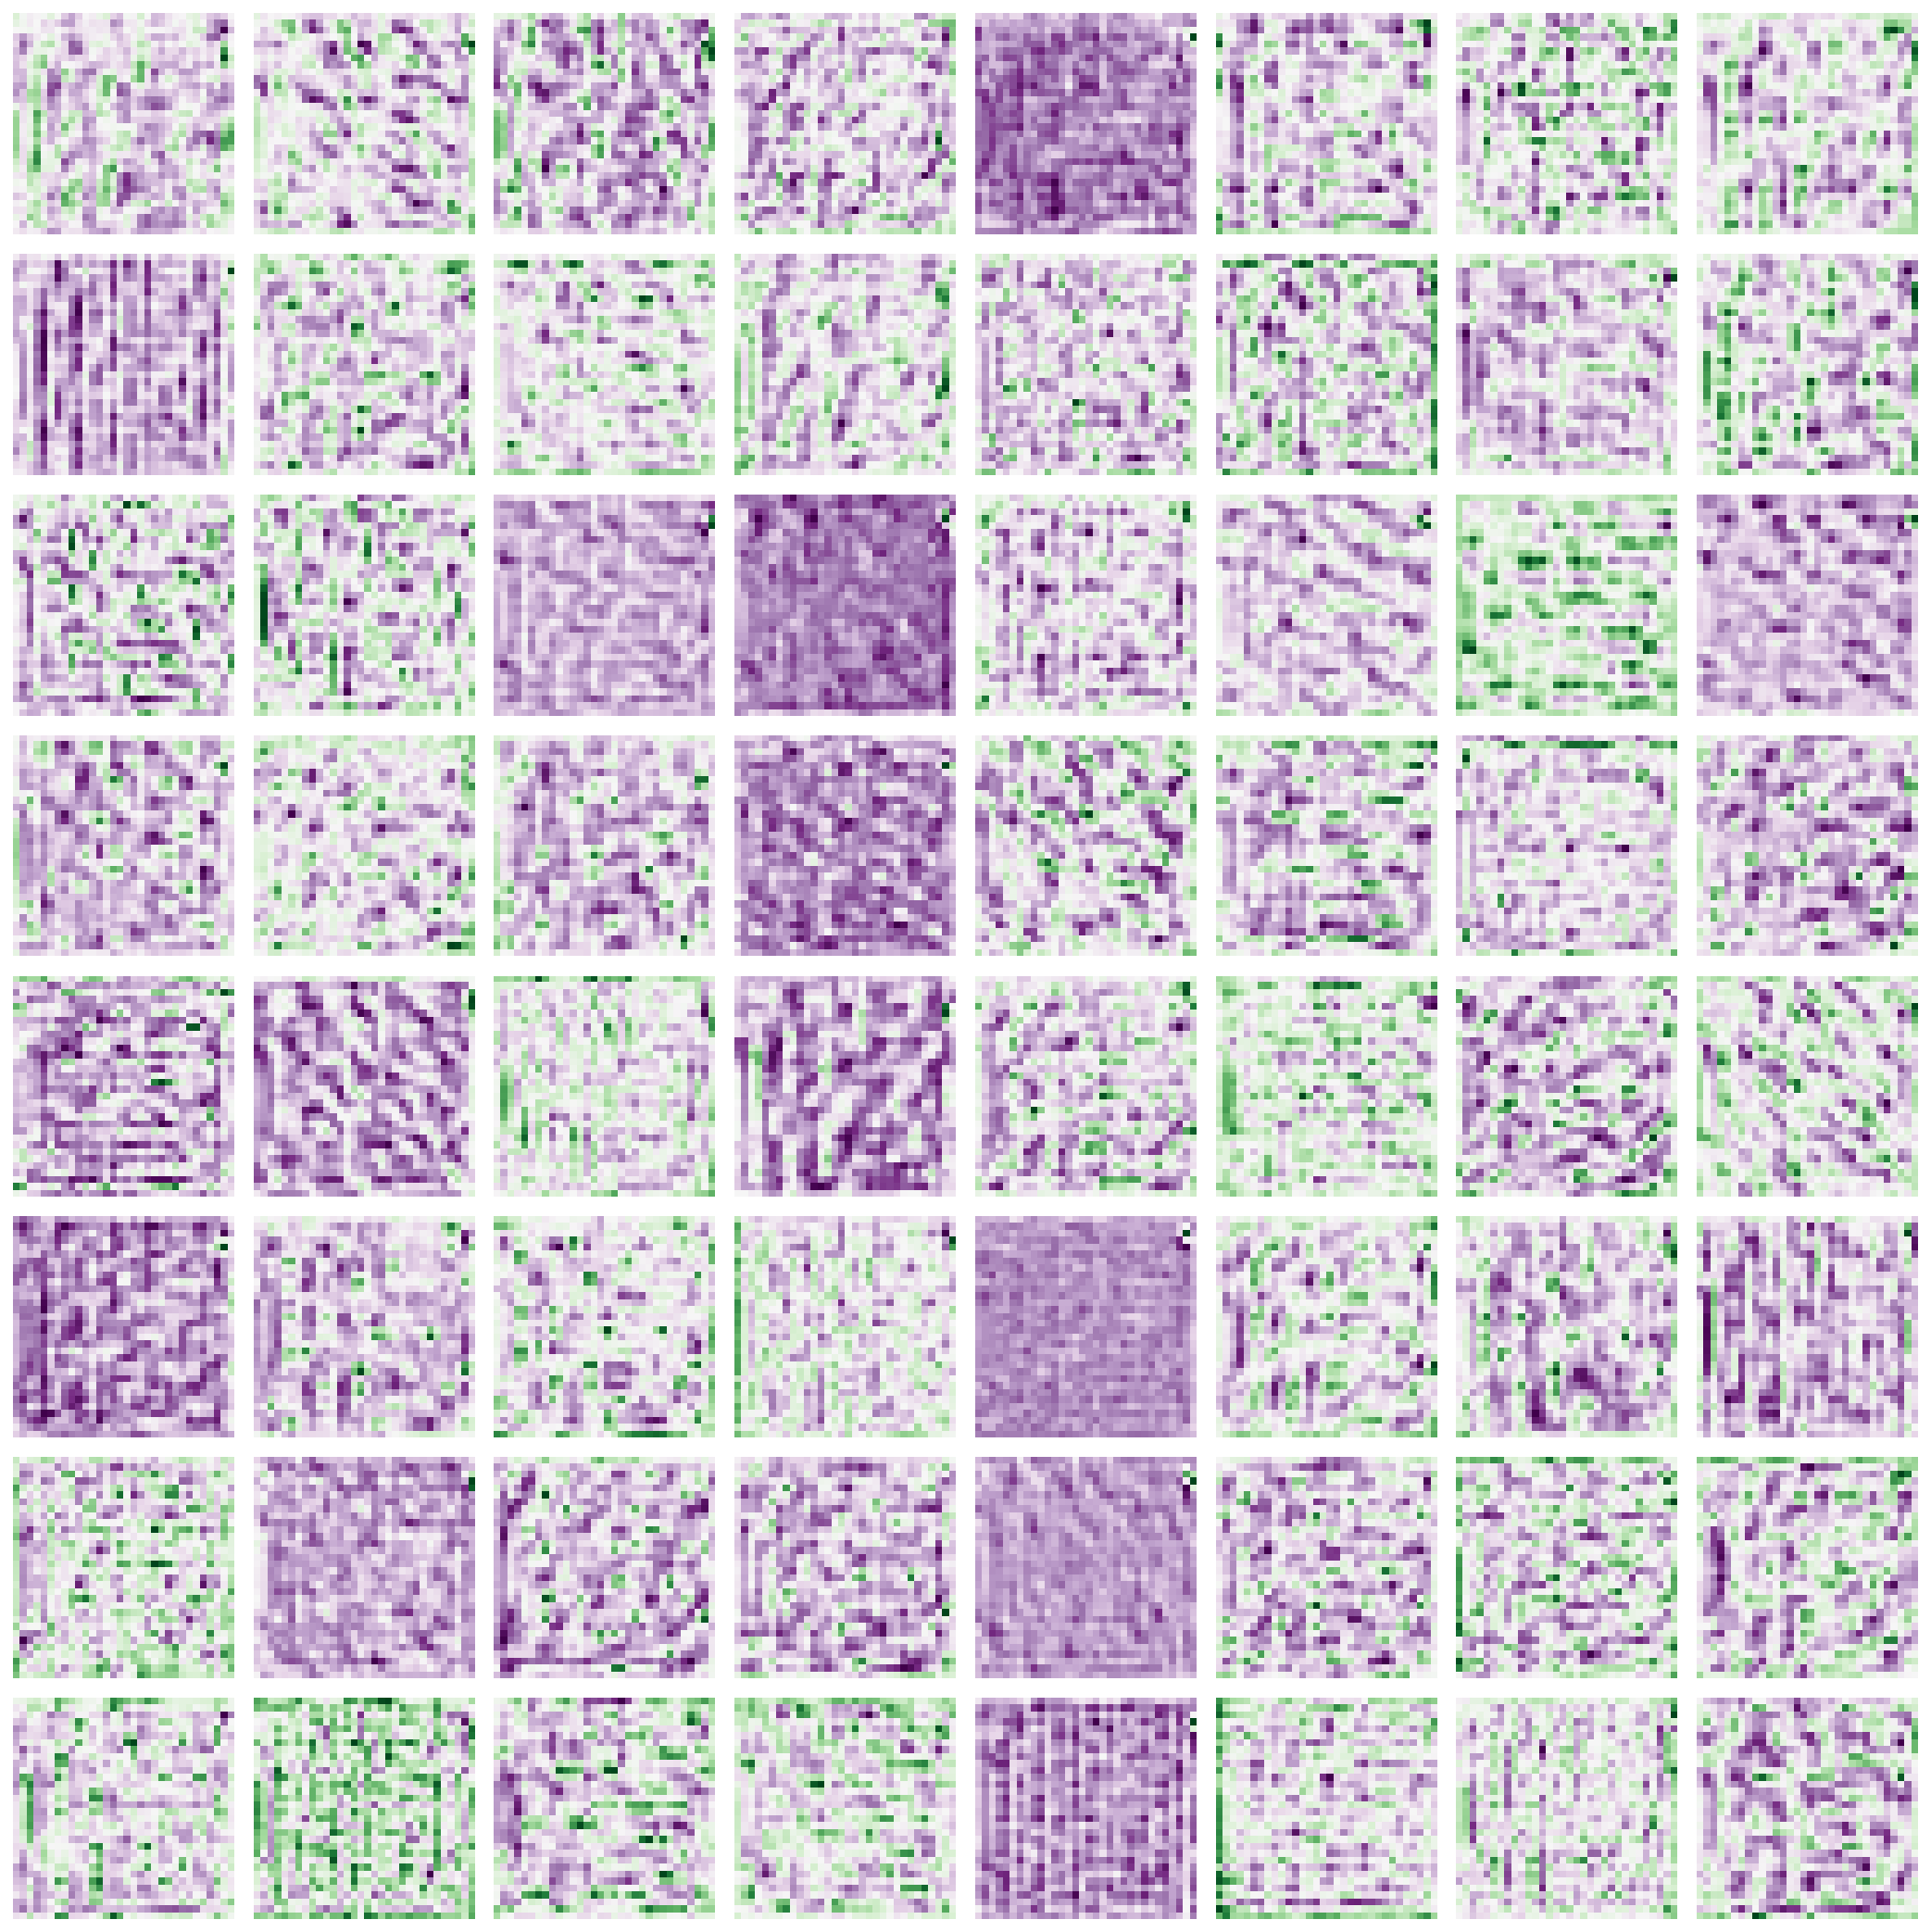

In [15]:
# Convolutional Layer 3-5 in the summary above

# Reset visualisation dict.
visualisation = {}

# Set hook at conv layer in next impala block, which has 128 features
h = policy.embedder.block2.conv.register_forward_hook(hook_fn)

# feed forward
output = policy(batched_obs[1:])
focus = 0.0

for v in visualisation.keys():
    print(visualisation[v].shape)
    focus = visualisation[v]

fig, ax = plt.subplots(8, 8, figsize=(15, 15))
axes = ax.ravel()

# We can do the first 64 feature maps here to make this easier to view
    
for i in tqdm(range(focus[0].shape[0]//2)):
    row, col = divmod(i, 8)
    axes[i].imshow(focus[0, i, :, :].detach().numpy().T, cmap='PRGn')
    axes[i].axis('off')  # Optionally, turn off axis labels

plt.tight_layout()
plt.show()

h.remove()

100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 2390.98it/s]


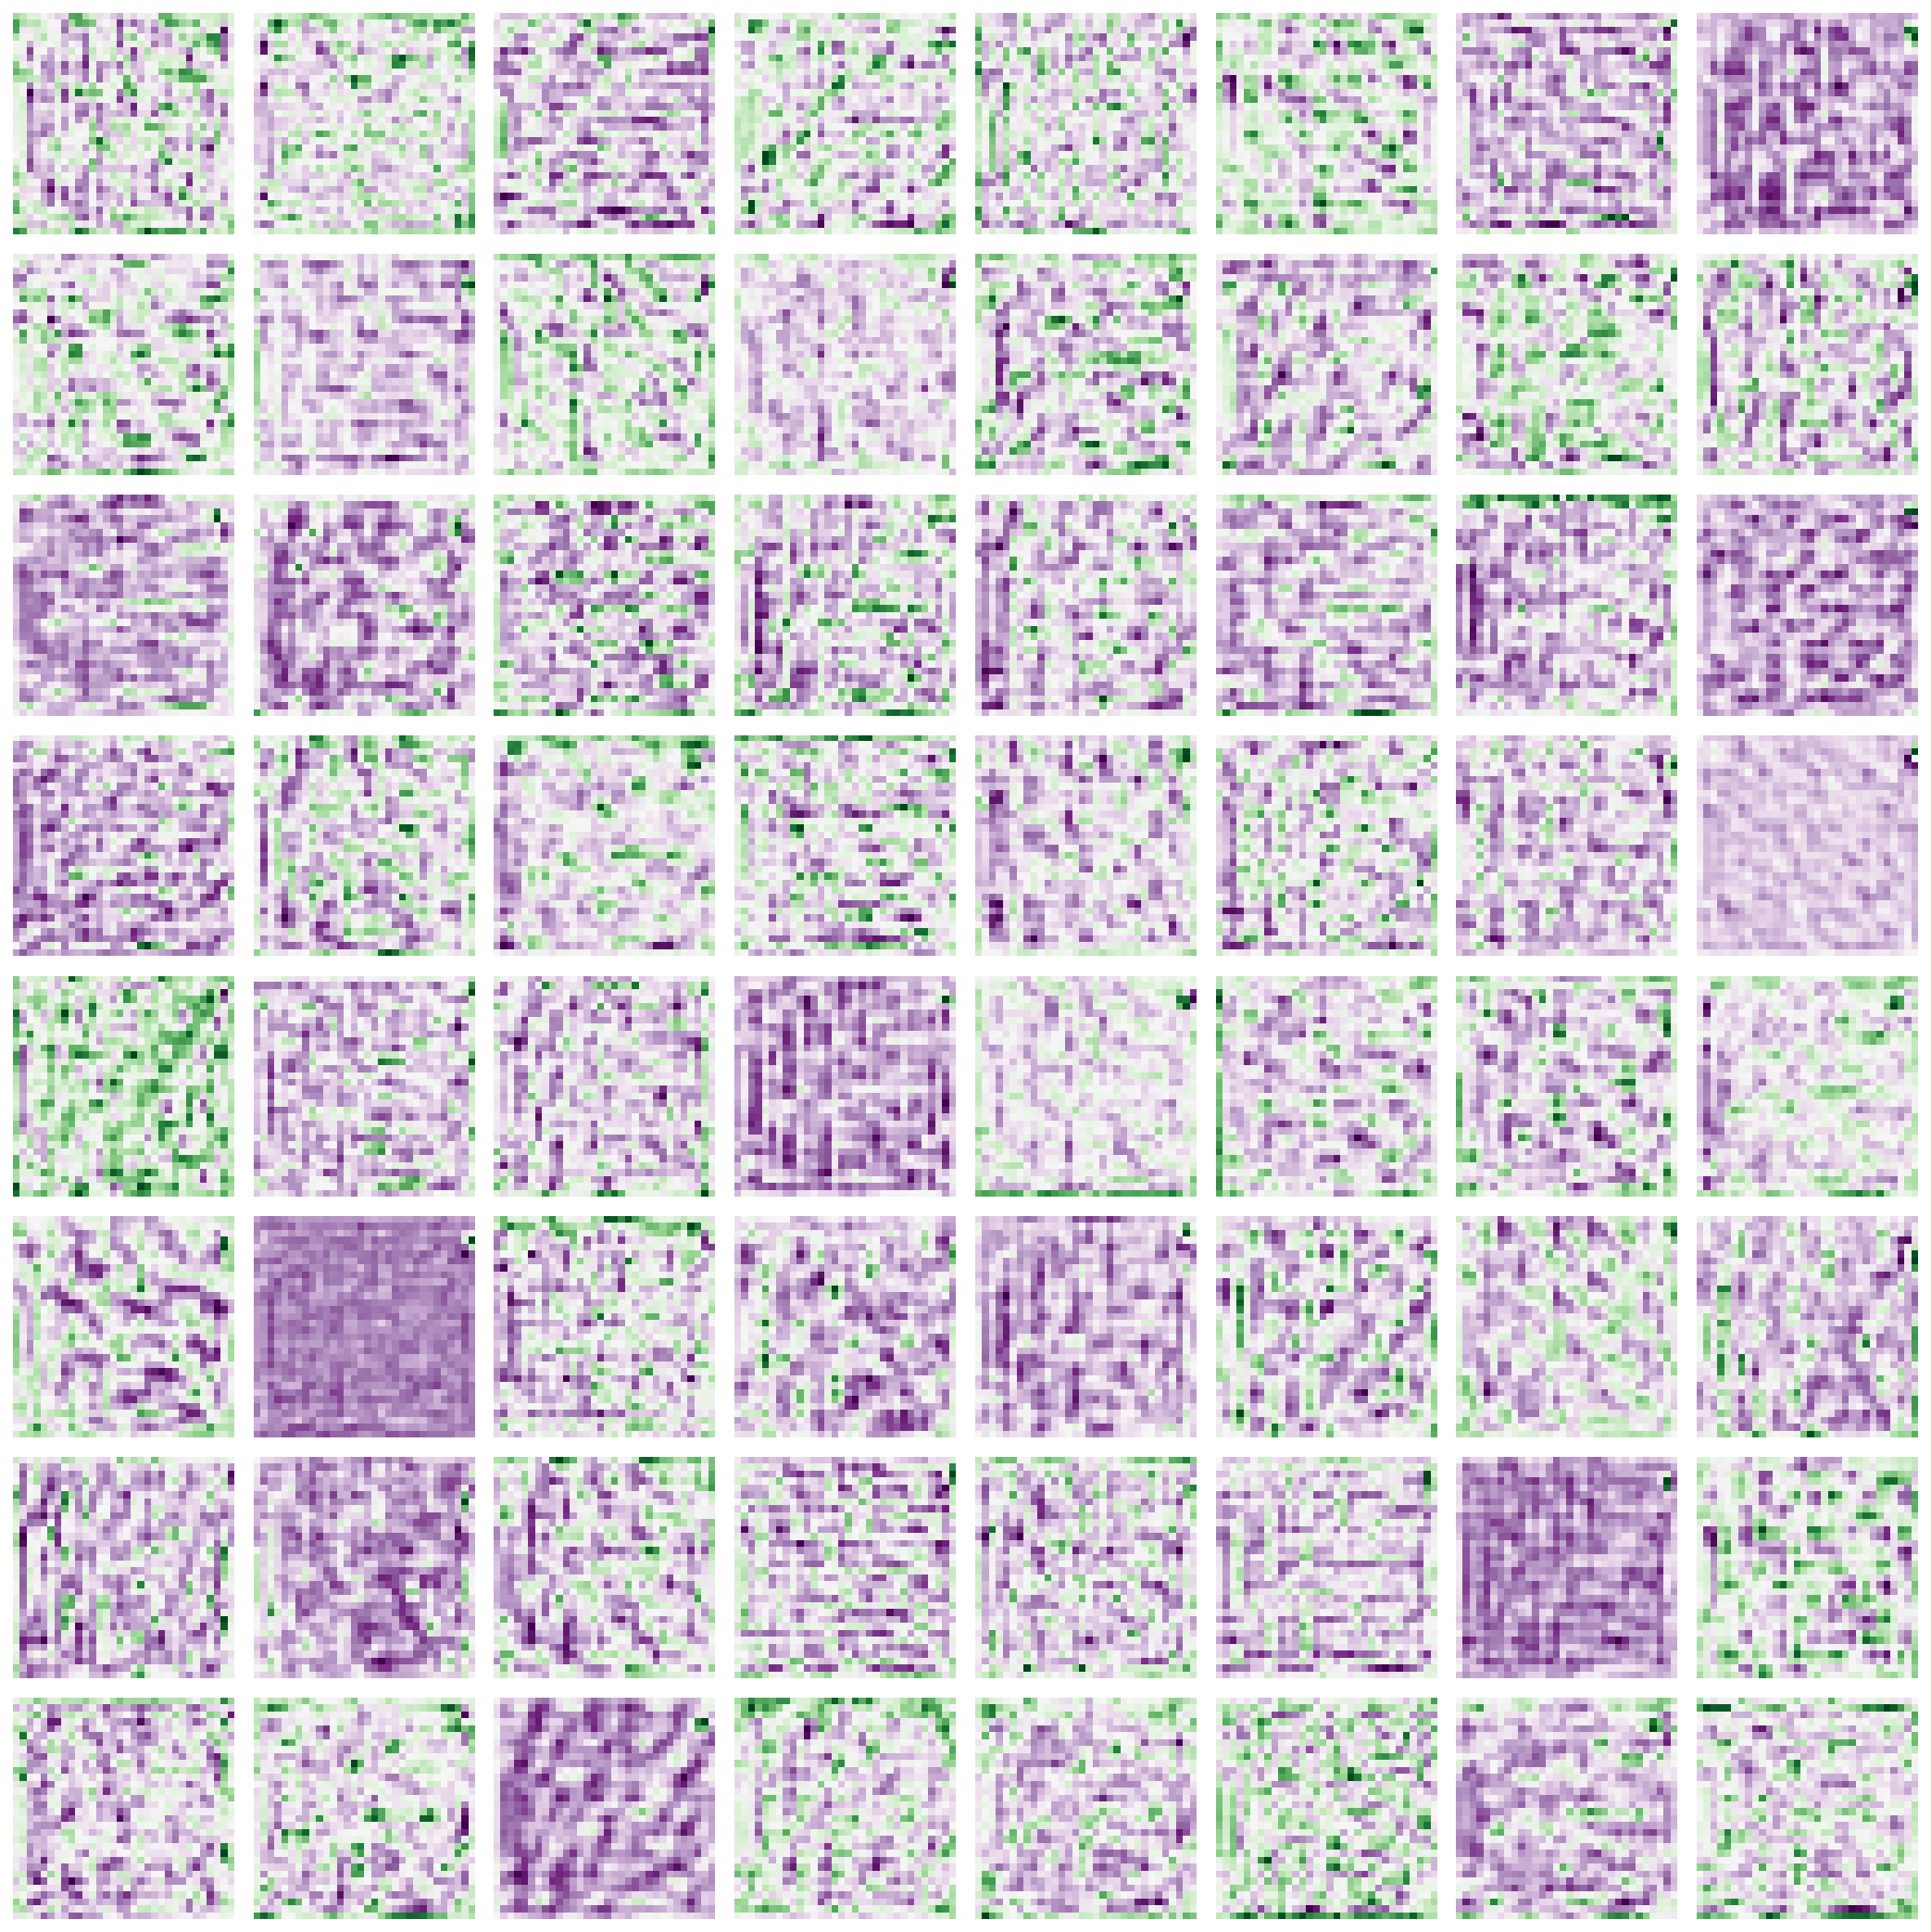

In [16]:
fig, ax = plt.subplots(8, 8, figsize=(15, 15))
axes = ax.ravel()

# These are the last 64 features
    
for i in tqdm(range(focus[0].shape[0]//2)):
    row, col = divmod(i, 8)
    axes[i].imshow(focus[0, i+64, :, :].detach().numpy().T, cmap='PRGn')
    axes[i].axis('off')  # Optionally, turn off axis labels

plt.tight_layout()
plt.show()


While this is significantly less interpretable than the above due to the decreased resolution, we do have a few points of interest here. 
1. It seems like, unlike the previous layer, the neural network may be starting to distinctly identify the mouse (actor) in the environment. A couple of feature maps point distinctly to the top right corner where the mouse would be. What is interesting though, is the peak activations are not in the top right pixel, which is where the mouse is in the environment. Rather it seems to be shifted down to the point below it. If that is due to a decrease in resolution or not, is hard to say.

/tmp/ipykernel_83594/3176022244.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  axes[0].imshow(batched_obs[:1].squeeze(axis=0).T)


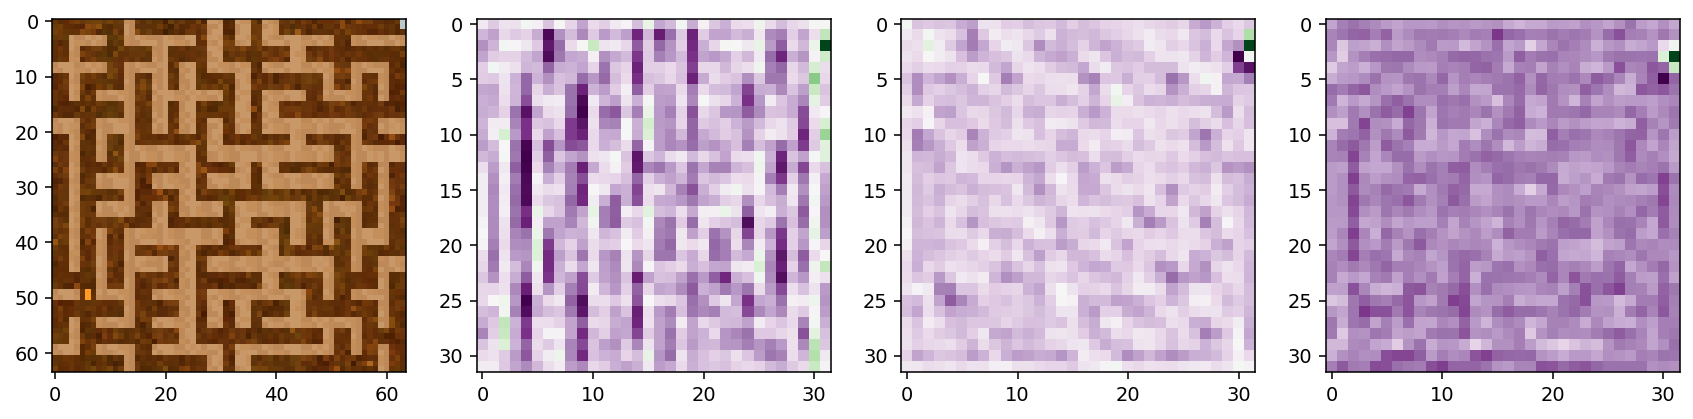

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
axes = ax.ravel()

axes[0].imshow(batched_obs[:1].squeeze(axis=0).T)
axes[1].imshow(focus[0, 8, :, :].detach().numpy().T, cmap='PRGn')
axes[2].imshow(focus[0, 95, :, :].detach().numpy().T, cmap='PRGn')
axes[3].imshow(focus[0, 105, :, :].detach().numpy().T, cmap='PRGn')

plt.show()

All of the above point to a distinct highlight at the top right hand corner, the area where the mouse is, but distinctly not the top right hand corner, which is exactly where the mouse is.

Another point of interest is:

2. Some feature maps distinctly highlight the top right hand corner and nothing else. We can hypothesize that is a distinct activation of the general area of where the mouse is. That being said, we notice no such maps for the cheese (goal) itself. In fact, there is an interesting lack of recognition of the goal: no singular feature map being activated at that area and nowhere else. 

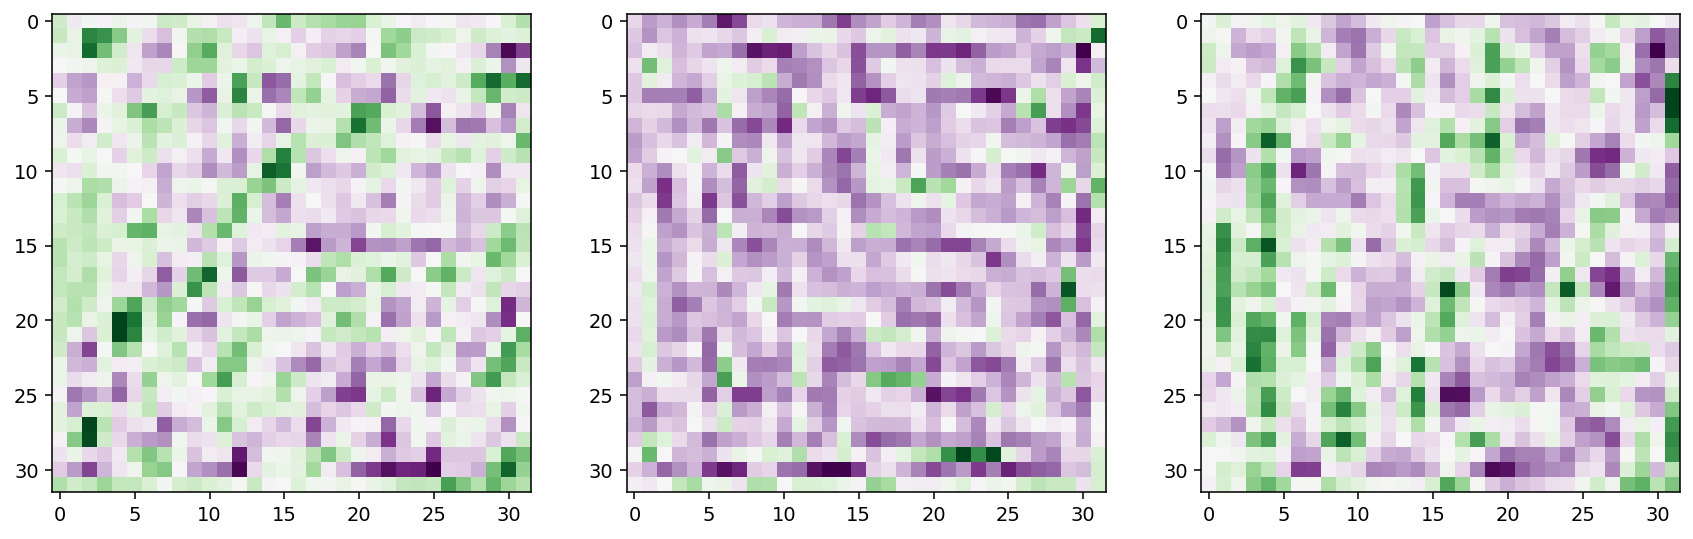

In [18]:
# The below images are examples of features highlighting somewhat close to the cheese, but it's not distinct, and has higher activations elsewhere.
fig, ax = plt.subplots(1, 3, figsize=(15, 15))

ax[0].imshow(focus[0, 8*8+3, :, :].detach().numpy().T, cmap='PRGn')
ax[1].imshow(focus[0, 8*8+6, :, :].detach().numpy().T, cmap='PRGn')
ax[2].imshow(focus[0, 1*8 + 7, :, :].detach().numpy().T, cmap='PRGn')



We notice a trend of less human-interpretability as the maps go deeper. For the sake of it, let's check out what happens one impala block deeper.

torch.Size([335, 128, 16, 16])


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 349.93it/s]


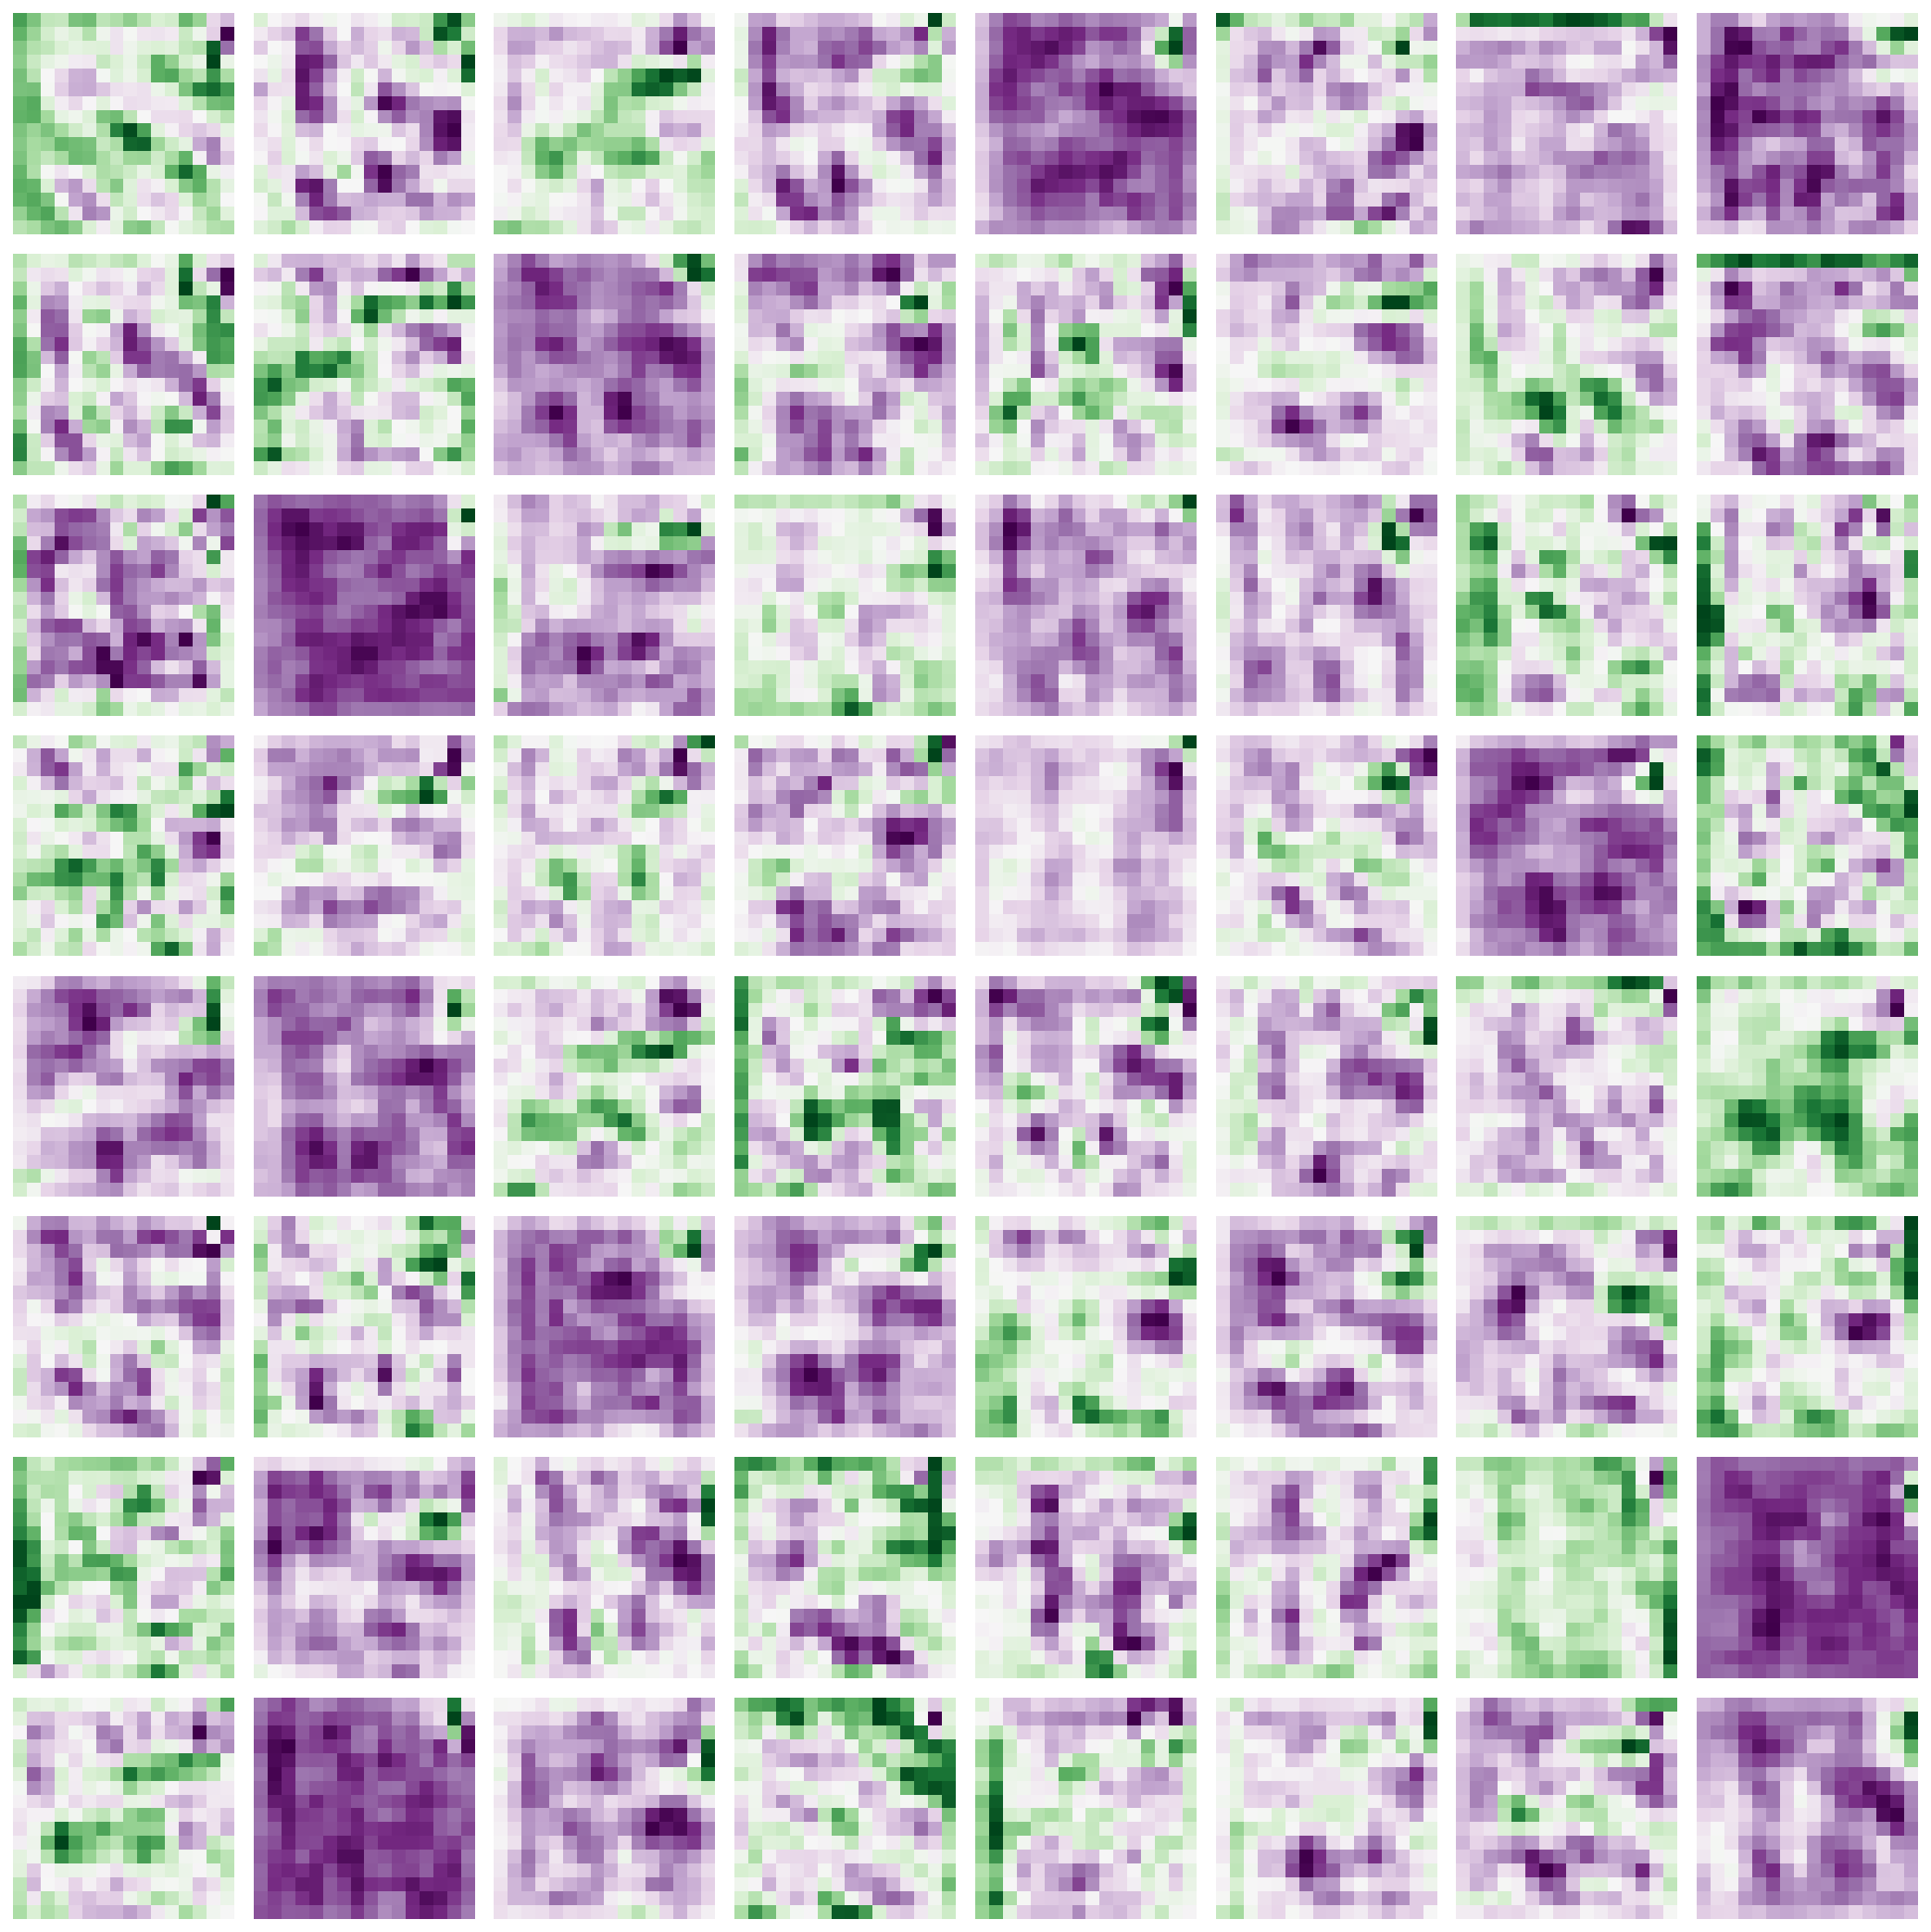

In [19]:
# Convolutional Layer 3-9 in the graph above

# Reset visualisation dict.
visualisation = {}

# Set hook at conv layer in next impala block, which has 128 features
h = policy.embedder.block3.conv.register_forward_hook(hook_fn)

# feed forward
output = policy(batched_obs[1:])
focus = 0.0

for v in visualisation.keys():
    print(visualisation[v].shape)
    focus = visualisation[v]

fig, ax = plt.subplots(8, 8, figsize=(15, 15))
axes = ax.ravel()

# We can do the first 64 feature maps here to make this easier to view
    
for i in tqdm(range(focus[0].shape[0]//2)):
    row, col = divmod(i, 8)
    axes[i].imshow(focus[0, i, :, :].detach().numpy().T, cmap='PRGn')
    axes[i].axis('off')  # Optionally, turn off axis labels

plt.tight_layout()
plt.show()

h.remove()

These are significantly less interpretable by virtue of reaching a very low resolution, so there's not much point in continuing to visualize feature maps as we go deeper. One thing to consider though, is that we don't have any identification of the cheese at this level. Meaning, the model makes a move independent of the goal at first. This is a questionable hypothesis to make, so to verify we can make some saliency maps to check what the model is looking at.

# 2. Saliency Maps

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def saliency(img, model):
    '''
    This code is modelled from this repo: 
    https://github.com/sunnynevarekar/pytorch-saliency-maps/tree/master

    A few changes have been made to have the function cooperate with our task at hand.
    '''
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    img.requires_grad = True
    #forward pass to calculate predictions
    preds = model(img)
    score_ind = t.argmax(preds[0].logits)
    logits = preds[0].logits
    score = logits[0, score_ind]

    print("The predicted correct move in this scenario is: ", score_ind.numpy())
    
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = t.max(t.abs(img.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    return slc.numpy()

The predicted correct move in this scenario is:  5


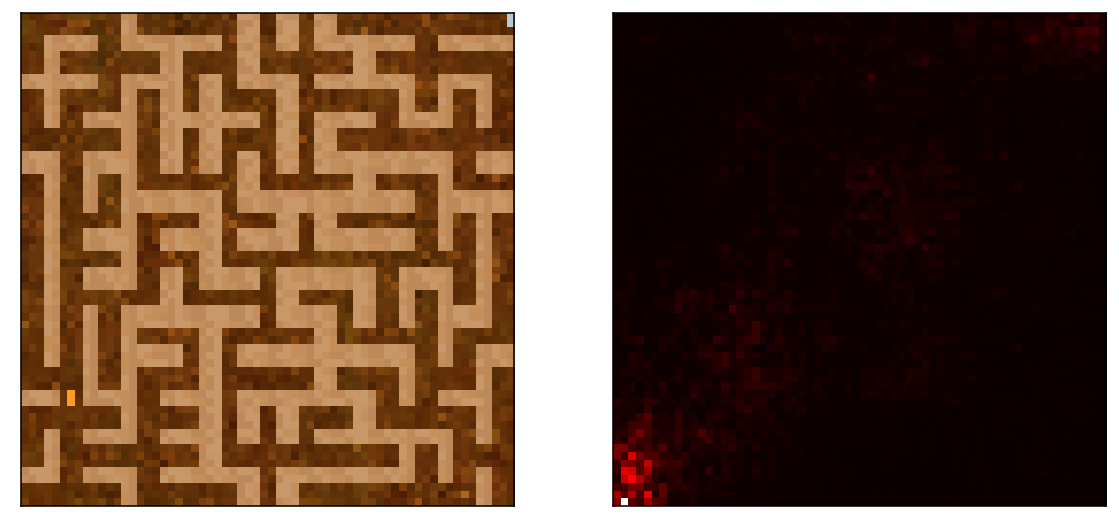

In [21]:
sal_map = saliency(batched_obs[:1], policy)

#plot image and its saleincy map
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(batched_obs[:1].squeeze(axis=0).T.detach().numpy())
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(sal_map, cmap=plt.cm.hot)
plt.xticks([])
plt.yticks([])
plt.show()

At first, this output doesn't make too much sense. Putting the images over each other would mean the model only focuses on the bottom left hand side, the exact opposite of where the mouse is, and a few pixels away from where the cheese is. To understand this more, we have to identify a few things. 

The authors of this original paper have complexified the environment significantly more than they needed to in order to make this work. Two of the ways they did that are: 

1. They added 15 different possible moves instead of 5, having a few moves overlap in functionality.
2. They flip the environment along the $y=-x$ axis when feeding the input into the model.

The code below is the dictionary they use to identify what index means what move, found in the model code itself.

In [22]:
# From procgen_tools/models.py, line 186
MAZE_ACTION_INDICES = {
    'LEFT': [0, 1, 2],
    'DOWN': [3],
    'UP': [5],
    'RIGHT': [6, 7, 8],
    'NOOP': [4,9,10,11,12,13,14],
}

Looking at this, we see the move chosen (5) actually means up, which only makes sense when we make the rotation. In other words, the saliency mapping corresponds to the following:

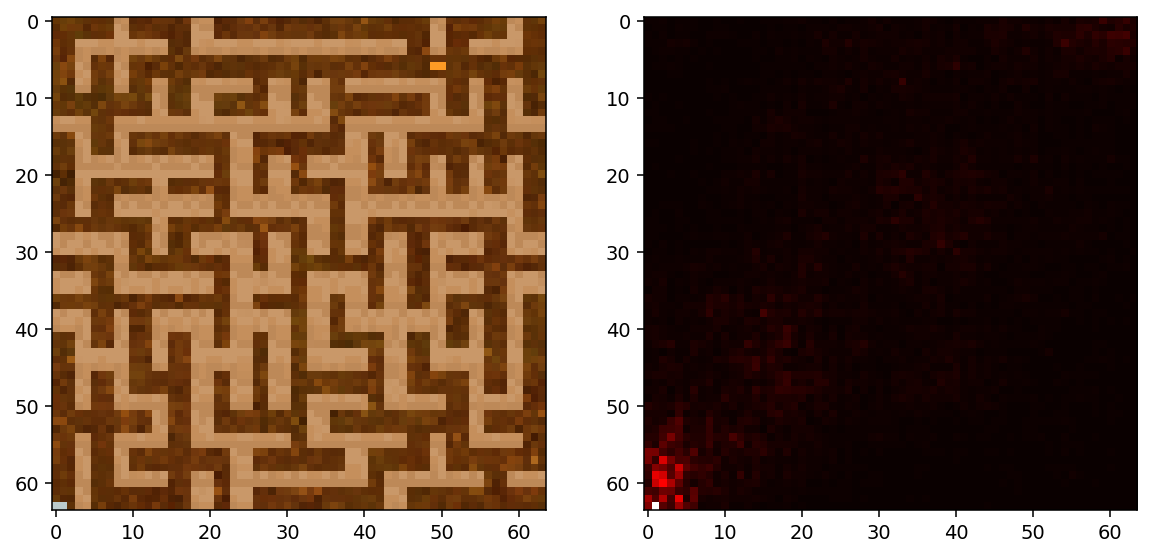

In [23]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(batched_obs[:1].squeeze(axis=0).numpy().transpose(1,2,0))
plt.subplot(1, 2, 2)
plt.imshow(sal_map, cmap=plt.cm.hot)
plt.show()

The first glaring feature of this is that the model eventually learns to identify the right move despite being fed the wrong orientation. 

Another point of interest as well, there is still no recognition of the cheese while it's making this move. It begs the question: The entire input image is sent through to the encoder, so regardless of where it goes, why wouldn't the cheese be identified despite consisting of the only unique RBG pixels in the 3x64x64 image outside of the mouse, regardless of the fact that it is the goal? At what point does the model begin to identify the cheese?

The predicted correct move in this scenario is:  5


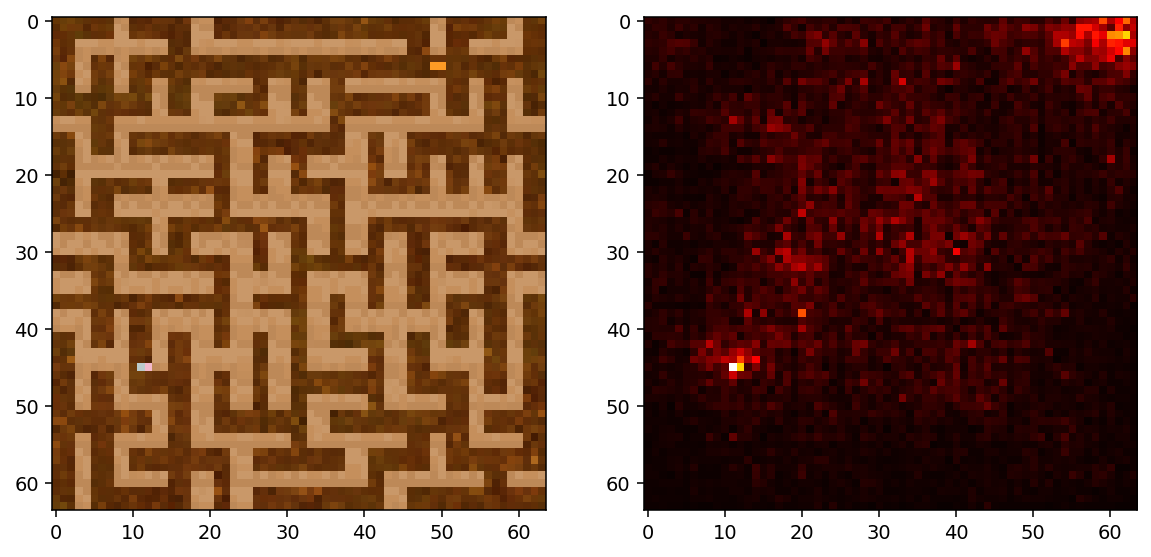

In [24]:
highlighted_map = batched_obs[102:103]

sal_map = saliency(highlighted_map, policy)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(highlighted_map.squeeze(axis=0).detach().numpy().transpose(1,2,0))
plt.subplot(1, 2, 2)
plt.imshow(sal_map, cmap=plt.cm.hot)
plt.show()

Another one of the goals in the initial paper was to promote misgeneralization, in that the models were only ever trained on scenarios where cheese was in the top right hand corner to make the model want to only move towards the right hand corner. This may be an example of a proof of that misgeneralization.

More work is to be done here, specifically we want to look at how the saliency maps change when the cheese is placed in a distinctly seperate location.

# 3. Feature Visualization

This was an idea that was more or less introduced in the paper [Feature Visualization by Chris Olah](https://distill.pub/2017/feature-visualization/) in 2017. The goal of this is to optimize an input such that it gives us optimal behaviour in the form of an image that maximizes the input of a specific kernel or neuron. In other words, this method allows us to create an image from noise that effectively tells us what the neuron does, or looks for. 

An alternative method to doing this, as mentioned in the paper, is to go through our dataset and specifically associate images with peak activations of specific neurons. While this may help for some neurons, it's very unintuitive for others. We go through examples here:

### 3.1 Associating Samples with Neurons

It can be clear, for example, to associate certain samples with the actual outputted moves. We show that here.

Side note:
For some reason, the authors of this paper decided it would be optimal to have redundant actions. They are categorized as the following: 

In [25]:
output = policy(batched_obs)
print(output[0])
print(output[1].shape)

Categorical(logits: torch.Size([336, 15]))
torch.Size([336])


The output[0] corresponds to the probability distribution over the action space, and output[1] corresponds to the value function of that state. Using this, we can get the max value of each sample. 

In [26]:
act_probs = output[0].log_prob(t.tensor((0))).unsqueeze(axis=0)
for i in range(1, 15, 1):
    act_probs_temp = output[0].log_prob(t.tensor((i))).unsqueeze(axis=0)
    act_probs = t.cat((act_probs, act_probs_temp), 0)

print(act_probs.shape)

torch.Size([15, 336])


In [27]:
out, inds = t.max(act_probs.T ,dim=1)
print(inds)

tensor([5, 6, 6, 6, 6, 5, 5, 7, 8, 8, 6, 6, 6, 5, 6, 8, 8, 8, 5, 1, 5, 5, 3, 5,
        5, 5, 5, 5, 3, 6, 6, 5, 0, 0, 8, 7, 5, 0, 0, 6, 6, 5, 5, 1, 1, 1, 1, 5,
        3, 5, 5, 5, 5, 3, 8, 8, 3, 0, 0, 5, 8, 8, 8, 8, 5, 6, 6, 5, 2, 2, 2, 2,
        8, 8, 3, 3, 3, 5, 3, 3, 5, 5, 3, 3, 3, 3, 5, 0, 0, 3, 3, 5, 2, 2, 1, 2,
        3, 8, 3, 5, 3, 3, 5, 3, 3, 5, 3, 3, 5, 3, 3, 5, 5, 3, 5, 3, 5, 3, 8, 3,
        3, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 8, 8, 8, 8, 6, 6, 8, 8, 5, 8, 8, 5,
        3, 5, 5, 8, 8, 5, 5, 3, 5, 5, 5, 5, 5, 6, 6, 3, 8, 8, 5, 1, 2, 5, 6, 6,
        5, 0, 2, 5, 5, 8, 5, 0, 0, 3, 5, 5, 3, 5, 3, 5, 5, 8, 8, 6, 8, 3, 6, 6,
        6, 6, 6, 6, 3, 5, 3, 2, 0, 0, 0, 0, 0, 5, 3, 3, 3, 5, 5, 3, 3, 3, 3, 8,
        8, 3, 5, 5, 2, 2, 6, 7, 5, 5, 5, 5, 3, 3, 5, 5, 3, 5, 5, 5, 5, 3, 5, 8,
        8, 8, 8, 3, 6, 6, 6, 6, 5, 3, 6, 6, 6, 6, 5, 0, 0, 5, 5, 5, 8, 8, 8, 8,
        5, 5, 8, 8, 5, 5, 5, 2, 2, 2, 2, 5, 5, 5, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5,
        3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8,

In [28]:
# Make a new dictionary for the samples themselves:
action_samples = {
    'LEFT': [],
    'DOWN': [],
    'UP': [],
    'RIGHT': [],
    'NOOP': [],
}

for sample in range(inds.shape[0]):
    for actions in MAZE_ACTION_INDICES.keys():
        if inds[sample] in MAZE_ACTION_INDICES[actions]:
            action_samples[actions].append(sample)
            break
        else:
            pass

In [29]:
for actions in MAZE_ACTION_INDICES.keys():
    print(f"Samples corresponding to move {actions} = {len(action_samples[actions])}")

Samples corresponding to move LEFT = 46
Samples corresponding to move DOWN = 68
Samples corresponding to move UP = 111
Samples corresponding to move RIGHT = 111
Samples corresponding to move NOOP = 0


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1718.98it/s]


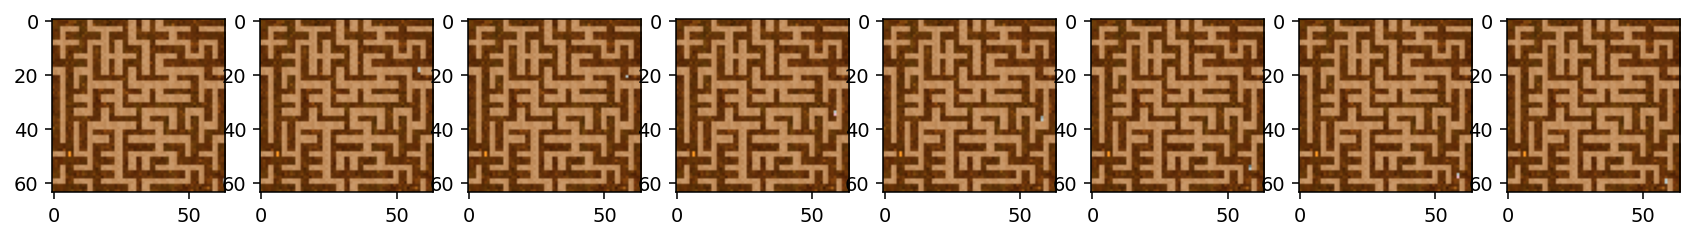

In [30]:
# Let's print a few of these
fig, ax = plt.subplots(1, 8, figsize=(15, 15))
    
for i in tqdm(range(8)):
    specific_sample = action_samples["LEFT"][i]
    ax[i].imshow(batched_obs[specific_sample].T)

# Remember, the actions themselves correspond to the *unflipped* versions of the images.
# In this case, movement up = movement left.

It's significantly less clear if you don't really understand what the kernel is doing, which happens to be the case for almost all of our kernels.

In [31]:
# Convolutional Layer 3-5 in the summary above

# Reset visualisation dict.
visualisation = {}

# Set hook at conv layer in next impala block, which has 128 features
h = policy.embedder.fc.register_forward_hook(hook_fn)

# feed forward
output = policy(batched_obs)
focus = 0.0

for v in visualisation.keys():
    focus = visualisation[v]

print(focus.shape)
max_values, max_indices = t.max(focus.T, axis=1)
print(max_indices)
h.remove()

torch.Size([336, 256])
tensor([332, 163,   0, 168,  22, 280,  17, 198,  78,  87,   1, 119,  16, 270,
        271,  88, 311, 234, 328, 139, 182,  27, 158, 119,  56, 139, 257,  31,
        151,  27, 210, 304, 142,  16, 192, 256,  40,   1, 280, 198, 278, 221,
         28,  93, 260, 280,  87, 163, 182, 280, 280, 260,  88, 311, 291,  32,
        198, 255, 198,  88, 312,  28, 260, 117, 126, 313, 224, 311, 210,  40,
        168, 288,  53, 182,  28, 180, 271, 182, 192, 220, 271,  31, 165, 326,
         13, 260, 280, 210, 216,   1,  17, 173,  67,  93, 109,  74,  80, 180,
        333, 312, 284, 278,  93,  31,   1, 163, 189,  53, 182,   4, 150, 163,
        260, 260, 182,   9, 134, 310, 140, 264, 280, 148, 107,  40, 260, 220,
        312, 182, 133, 304,   1,  87, 123, 271,  27,  42, 119, 312,  87, 159,
        159, 241,  88, 139, 253, 311, 136,  79, 312, 129, 198,  42, 248,  27,
        283,  93,  28, 129, 182,   1, 177, 305,  45, 326, 270,  22, 163, 189,
        256,  13, 151, 281, 180,  40, 182

What we've found above is the associated highest sample in our batched_obs for every neuron in the fully connected layer at 2-6. So, in other words, our third neuron on that layer is maximally activated by our very first sample. This is not a very helpful thing to see, so we have to rely on other methods.

### 3.2 Action Visualization

Admittedly, there's been a lot of trouble with trying to get this to work in any meaningful capacity. We've tried many different kinds of noises and played with the loss function a bunch. More work has to be done here to make this work as intended.

In [32]:
import numpy as np
from perlin_noise import PerlinNoise

noise = PerlinNoise(octaves=8, seed=1)
chan, xpix, ypix = 3, 64, 64
perl = np.array([[[noise([i/xpix, j/ypix]) for j in range(xpix)] for i in range(ypix)] for _ in range(chan)])
new_input = t.tensor(perl, requires_grad=True, dtype=t.float32).unsqueeze(axis=0)
print(new_input.shape)

torch.Size([1, 3, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


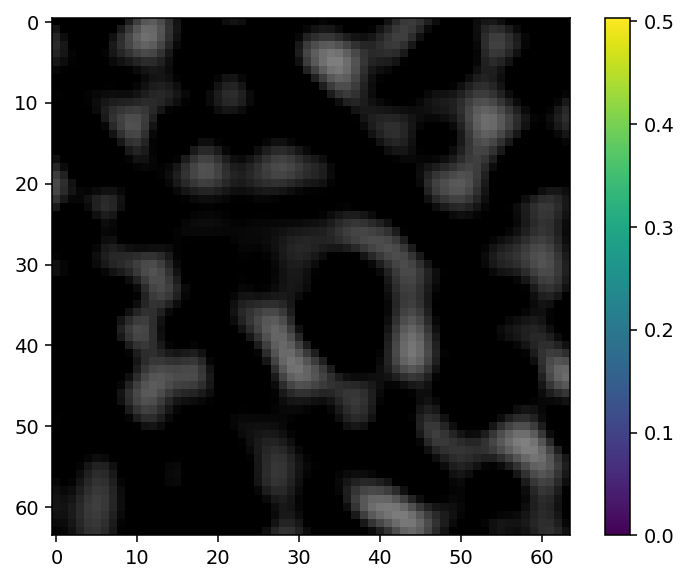

In [33]:
# Perlin Noise
old_input = new_input.clone()

plt.imshow(new_input.squeeze(axis=0).detach().numpy().T)
plt.colorbar()
plt.show()

In [34]:
epochs = 200
lr = 1e-2
losses = []
avg_activation = []
for e in tqdm(range(epochs)):
    visualisation = {}
    h5 = policy.embedder.block2.conv.register_forward_hook(hook_fn)
    new_input.retain_grad()
    output = policy(new_input)

    focus = 0.0
    for i, v in enumerate(visualisation.keys()):
        focus = visualisation[v]

    #print(focus[0, 0, :, :])
    target = t.ones(focus[0, 0, :, :].shape)*200# make a large target of the correct dims
    loss = t.sum(target - focus)

    # Grab losses and avg_activation
    losses.append(loss.detach().numpy())
    #print(focus[0, :, :, :])
    avg_activation.append(t.sum(focus[0, 1].detach()).numpy())
    
    loss.backward()
    gradient = new_input.grad
    with t.no_grad():
        new_input -= lr*gradient
    h5.remove()
    
h5.remove()

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 131.64it/s]


Text(0.5, 1.0, 'Activation Curve')

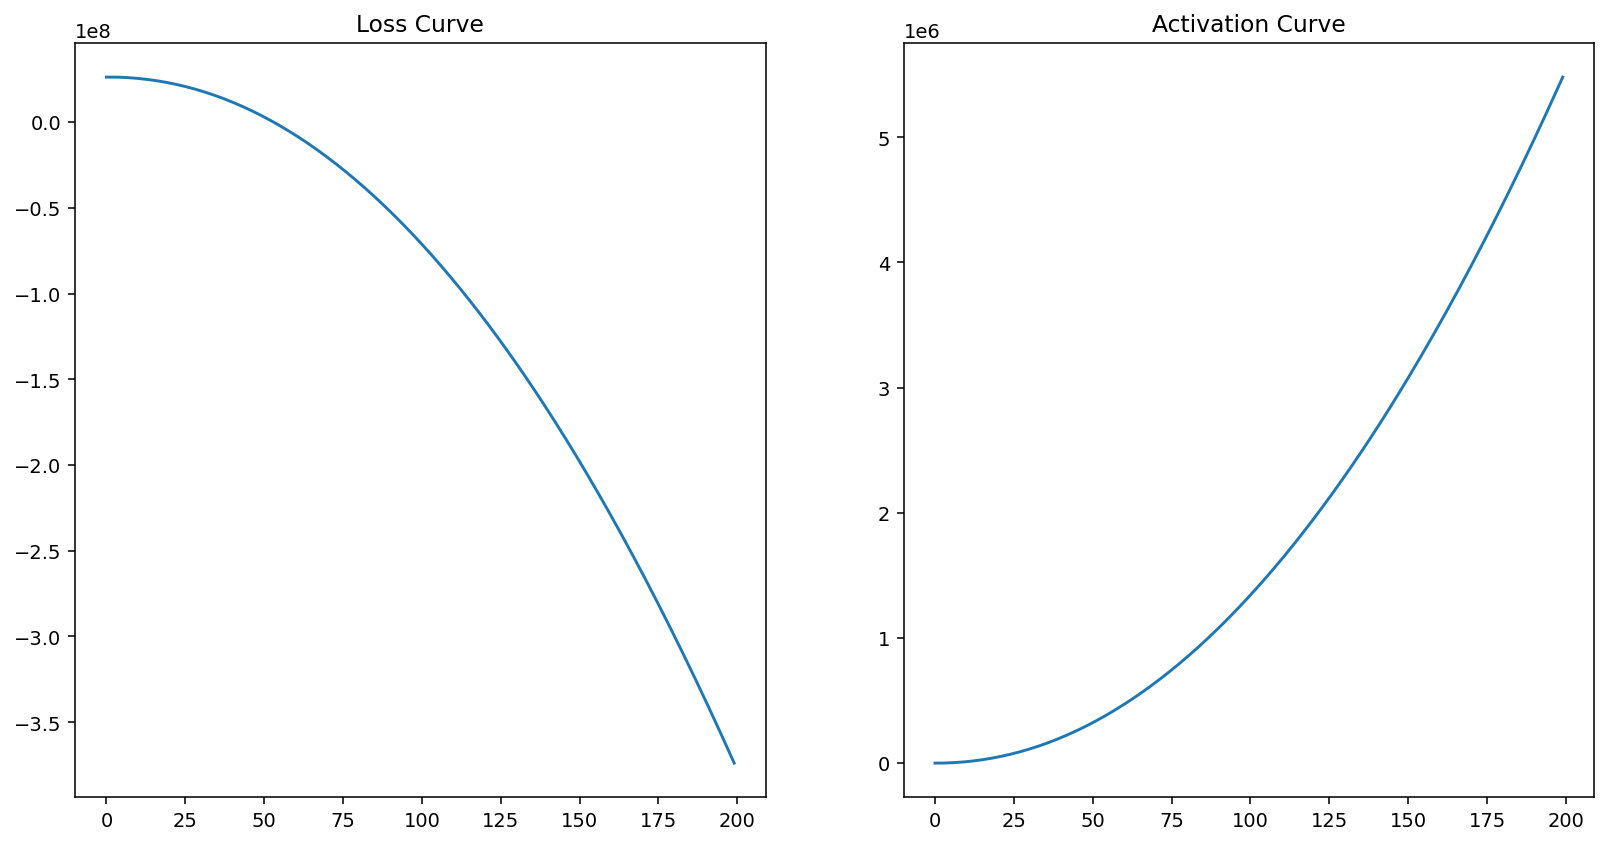

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].plot(losses)
ax[0].set_title("Loss Curve")
ax[1].plot(avg_activation)
ax[1].set_title("Activation Curve")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


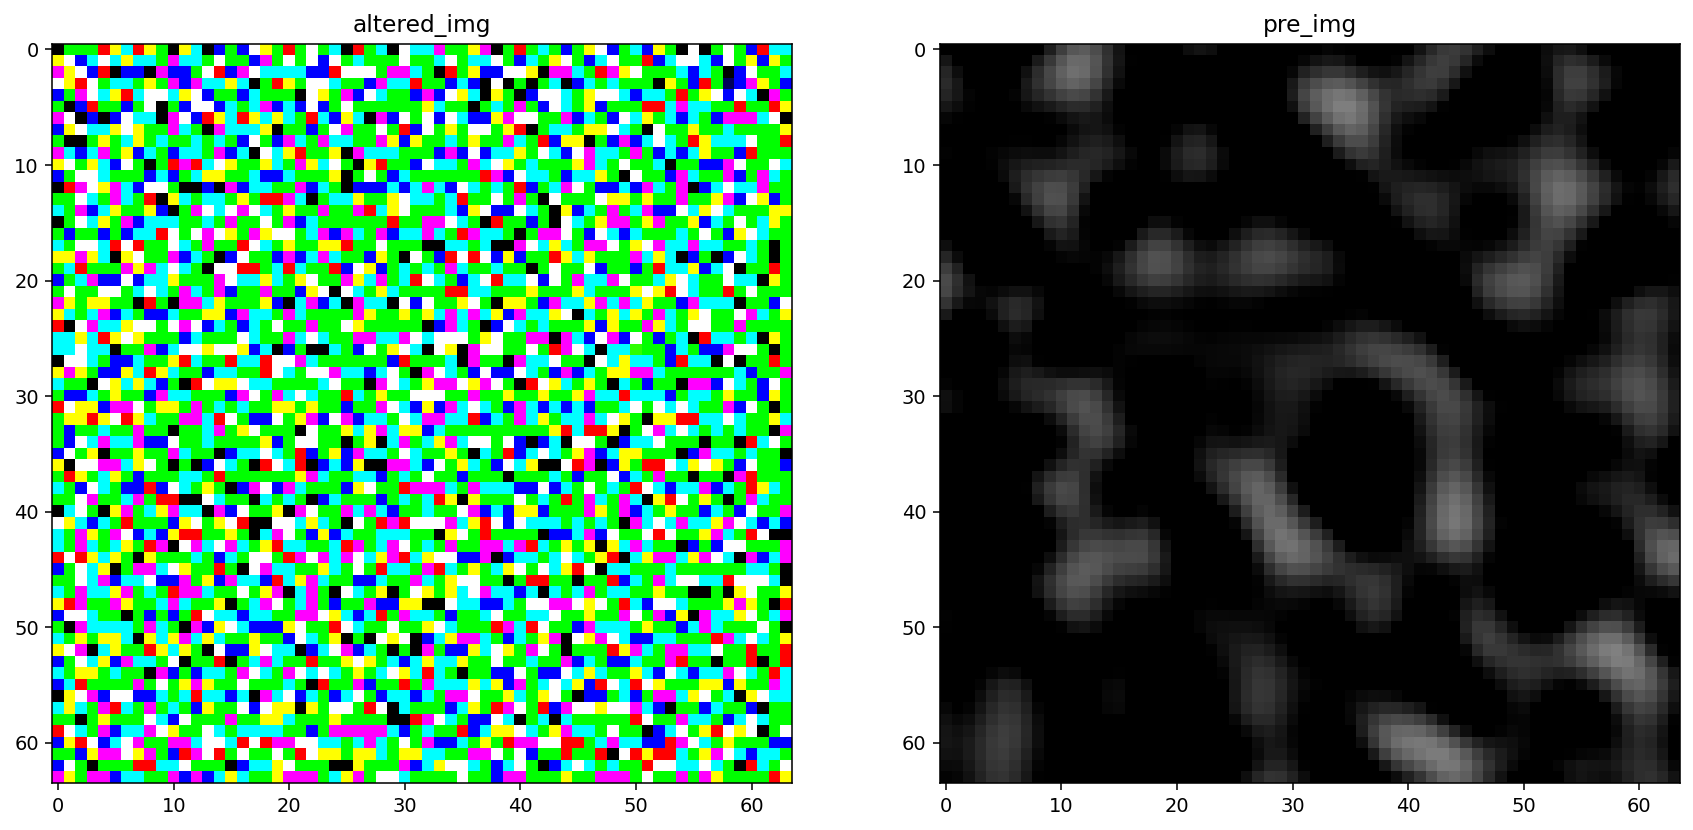

In [36]:
import matplotlib.pyplot as plt
f, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(t.squeeze(new_input.detach(), axis=0).numpy().T)
axs[0].title.set_text('altered_img')
axs[1].imshow(t.squeeze(old_input[0].detach(), axis=0).numpy().T)
axs[1].title.set_text('pre_img')

# not entirely sure how to make this not suck, so maybe worth reading lucids tutorial for more info?

In [45]:
# let's try this with the maze itself, maybe it will alter the image in a more predictable way
maze_input_img = batched_obs[3].clone().requires_grad_().unsqueeze(axis=0)
print(maze_input_img.shape)

epochs = 10
lr = 1e-4
losses = []
avg_activation = []
for e in tqdm(range(epochs)):
    visualisation = {}
    h5 = policy.embedder.block2.conv.register_forward_hook(hook_fn)
    maze_input_img.retain_grad()
    output = policy(maze_input_img)

    focus = 0.0
    for i, v in enumerate(visualisation.keys()):
        if i == 0:
            focus = visualisation[v]

    #print(focus[0, 0, :, :])
    target = t.ones(focus[0, 0, :, :].shape)*200# make a large target of the correct dims
    loss = t.sum(target - focus)

    # Grab losses and avg_activation
    losses.append(loss.detach().numpy())
    #print(focus[0, :, :, :])
    avg_activation.append(t.sum(focus[0, 1].detach()).numpy())
    
    loss.backward()
    gradient = maze_input_img.grad
    with t.no_grad():
        maze_input_img -= lr*gradient
    h5.remove()
    
  

torch.Size([1, 3, 64, 64])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 108.75it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


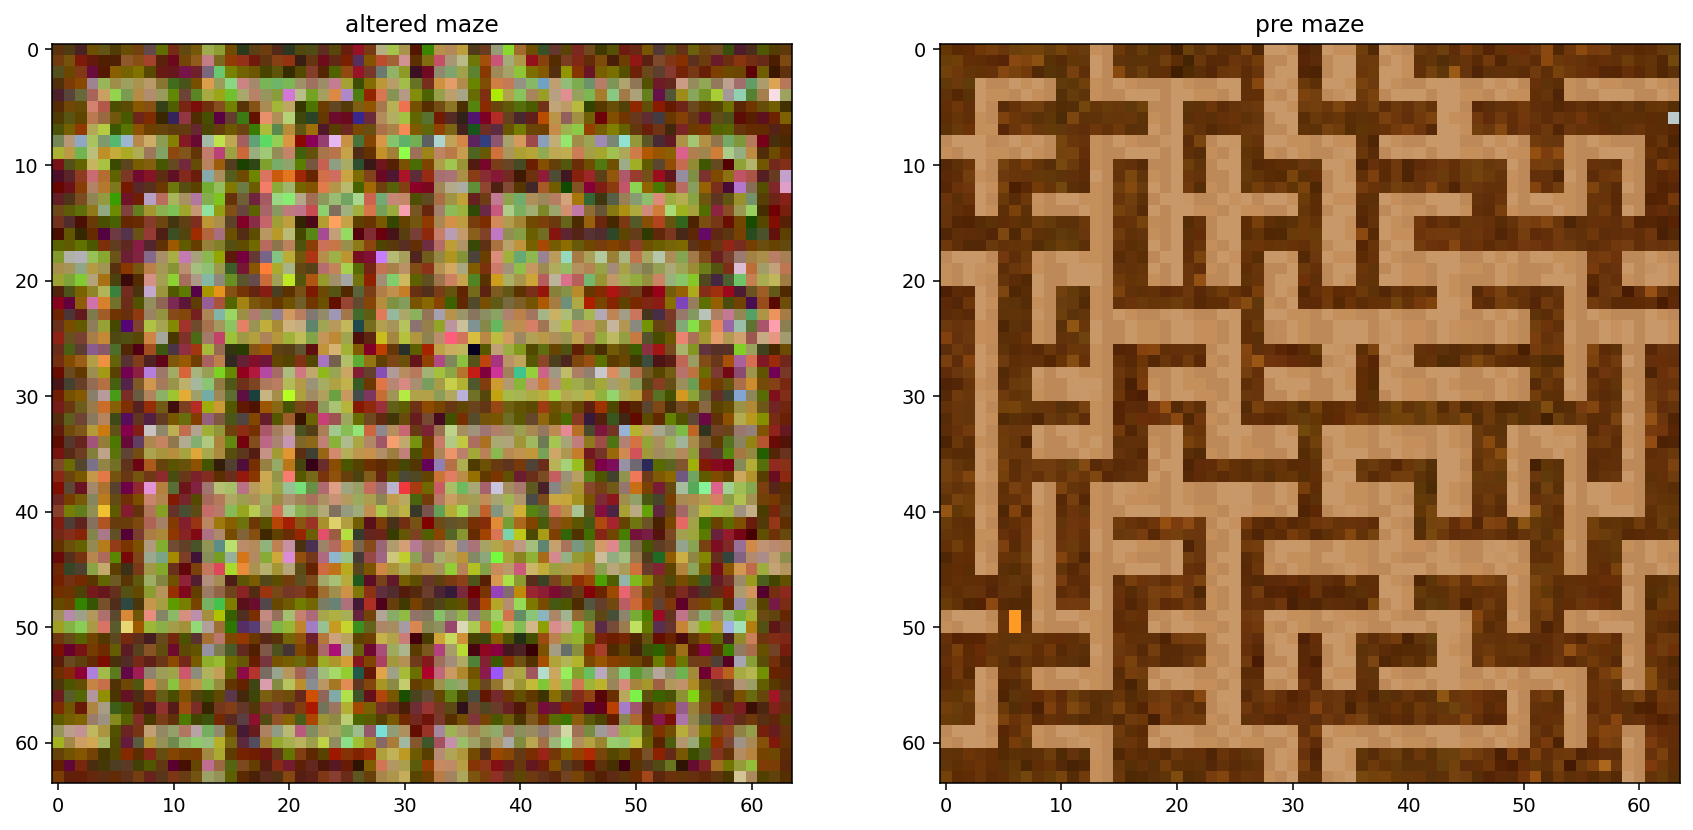

In [46]:
f, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(t.squeeze(maze_input_img.detach(), axis=0).numpy().T)
axs[0].title.set_text('altered maze')
axs[1].imshow(batched_obs[1].numpy().T)
axs[1].title.set_text('pre maze')

# not entirely sure how to make this not suck, so maybe worth reading lucids tutorial for more info?

In [347]:
from IPython.display import display, HTML
WARNING, DONT RUN THIS
display(HTML("""
<style>
    div.jp-Cell-outputWrapper {height: 40px; }
</style>
"""))
print("foo\n"*150)

foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo

